In [1]:
# -*- coding: utf-8 -*-
"""
The script demonstrates a comparison of vehicle times from AVL data to the
scheduled arrival time at one stop for one example trip.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from itertools import compress
import time
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import time
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

### Data loading and such.

In [2]:
# data = pd.read_csv('longjsons_parsed.csv')

Need to include timestamp in index (as well as values)

In [92]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('spark_parse/test2.txt',header=None)

# beware!  Bonan is still working on organizing the extract files.  these columns may change.
bustime.columns = ['route','lat','lon','timestamp','vehicle_id','trip_id','trip_date','shape_id',
                   'next_stop_id','dist_from_stop','stop_dist_on_trip','presentable_dist']

bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')

In [93]:
bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)
bustime.set_index('timestamp',append=True,drop=False,inplace=True)

# for demonstration, use a subset. Just get data for one line (B41) on one day.
tripDateLookup = "2015-01-06"
lineLookup = "MTA NYCT_B41"
bustime = bustime.xs((lineLookup,tripDateLookup),level=(0,2),
                           drop_level=False)
# note that the AVL dataframe must be sorted by timestammp, since iloc[]
# selection is used later in this script to find the earliest time
bustime.sort_index(inplace=True)
bustime['timestamp'] = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-01-06')

bustime['stop_dist_on_trip'] = bustime['stop_dist_on_trip'].convert_objects(convert_numeric=True)
bustime['dist_from_stop'] = bustime['dist_from_stop'].convert_objects(convert_numeric=True)
bustime['veh_dist_along_trip'] = bustime['stop_dist_on_trip'] - bustime['dist_from_stop']

print 'Finished loading BusTime data, parsing timestamps, and and slicing B41 line.'

Finished loading BusTime data, parsing timestamps, and and slicing B41 line.


In [94]:
bustime_distances = bustime.drop(['timestamp'],axis=1,inplace=False)
bustime_distances = bustime_distances.reset_index().drop(['route','trip_id','trip_date','vehicle_id','timestamp',
                                                'lat','lon','dist_from_stop','presentable_dist',
                                                'veh_dist_along_trip'],axis=1,inplace=False)
stop_distances = stop_distances.query('stop_dist_on_trip > 0')
stop_distances = bustime_distances.drop_duplicates(['shape_id','next_stop_id','stop_dist_on_trip'])
stop_distances.shape_id = stop_distances.shape_id.str.replace('MTA_','')
stop_distances.next_stop_id = stop_distances.next_stop_id.str.replace('MTA_','')


In [95]:
stop_distances = stop_distances.sort(['shape_id','stop_dist_on_trip']).reset_index(drop=True)
# verify that shape_id and next_stop_id is a valid primary key (that is, exactly one value for each index)
sum(stop_distances.duplicated(['shape_id','next_stop_id']))

0

In [96]:
# show the mean distance between stops on trips
stop_distances.groupby('shape_id')['stop_dist_on_trip'].diff().mean()

375.39760814249365

### Selecting a sample trip

In [4]:
"""
#qstr = ('Trip == "MTA NYCT_FB_B6-Weekday-SDon-043400_B41_16"')
qstr = ('Trip == "MTA NYCT_FB_B6-Weekday-SDon-040800_B41_28"')
bustime = data.query(qstr)
bustime.drop_duplicates(['vehicleID','RecordedAtTime'],inplace=True)
bustime.set_index(['Line','Trip','TripDate','vehicleID','RecordedAtTime'],
                  inplace=True,drop=True,verify_integrity=True)
# for now, use a truncated data set.  just get data for one line (M5).
tripDateLookup = "2016-05-25"
lineLookup = "MTA NYCT_B41"
avl_long = bustime.xs((lineLookup,tripDateLookup),level=(0,2),drop_level=False)
del bustime,data # to free up memory
"""

'\n#qstr = (\'Trip == "MTA NYCT_FB_B6-Weekday-SDon-043400_B41_16"\')\nqstr = (\'Trip == "MTA NYCT_FB_B6-Weekday-SDon-040800_B41_28"\')\nbustime = data.query(qstr)\nbustime.drop_duplicates([\'vehicleID\',\'RecordedAtTime\'],inplace=True)\nbustime.set_index([\'Line\',\'Trip\',\'TripDate\',\'vehicleID\',\'RecordedAtTime\'],\n                  inplace=True,drop=True,verify_integrity=True)\n# for now, use a truncated data set.  just get data for one line (M5).\ntripDateLookup = "2016-05-25"\nlineLookup = "MTA NYCT_B41"\navl_long = bustime.xs((lineLookup,tripDateLookup),level=(0,2),drop_level=False)\ndel bustime,data # to free up memory\n'

This will be one example of one route

In [97]:
avl_data = bustime
avl_data.shape_id = avl_data.shape_id.str.replace('MTA_','')
avl_data.next_stop_id = avl_data.next_stop_id.str.replace('MTA_','')

In [98]:
stop_distances

shape_id next_stop_id  stop_dist_on_trip
0    B410227       303270             334.47
1    B410227       303274             950.80
2    B410227       303276            1283.55
3    B410227       303277            1472.70
4    B410227       303222            2087.51
5    B410227       303223            2381.56
6    B410227       303224            2484.74
7    B410227       303227            2936.30
8    B410227       303229            3275.90
9    B410227       303230            3504.56
10   B410246       303222            1519.16
11   B410246       303224            1916.39
12   B410246       303232            3418.80
13   B410246       303235            4264.92
14   B410246       308348            5738.05
15   B410246       303242            6223.72
16   B410246       306325            7122.92
17   B410247       303224             397.12
18   B410247       303232            1899.52
19   B410247       303233            2115.32
20   B410247       303235            2745.65
21   B410247       308348            4218.77
22   B410247       303242            4704.44
23   B410247       306325            5603.64
24   B410249       303460               0.00
25   B410249       303223             293.93
26   B410249       303224             397.12
27   B410249       303227             848.68
28   B410249       303229            1188.27
29   B410249       303230            1416.93
..       ...          ...                ...
383  B410301       303307            5766.06
384  B410301       303308            6065.31
385  B410301       308369            6393.44
386  B410301       303310            6677.85
387  B410301       303311            6978.25
388  B410301       303312            7252.59
389  B410301       303313            7498.74
390  B410301       303314            7785.86
391  B410301       303315            8146.94
392  B410301       303316            8360.25
393  B410301       307840            8675.57
394  B410301       303318            8976.29
395  B410301       303319            9298.28
396  B410301       307516            9689.41
397  B410301       308557           10075.25
398  B410301       303323           10248.78
399  B410301       303324           10562.79
400  B410301       306318           10653.12
401  B410301       303326           10862.42
402  B410301       308152           11111.04
403  B410301       303328           11266.13
404  B410301       303329           11429.64
405  B410301       303330           11598.19
406  B410301       303331           11759.84
407  B410301       303332           11869.77
408  B410301       303333           12057.53
409  B410301       303334           12229.37
410  B410301       303335           12350.36
411  B410301       307895           12538.28
412  B410301       303337           12654.86

[413 rows x 3 columns]

In [99]:
# stop_distances2 = stop_distances.set_index(['shape_id','stop_dist_on_trip'])
# stop_distances3 = stop_distances.set_index(['shape_id'])
# stop_distances5 = stop_distances2.reset_index().query('stop_dist_on_trip > 0').set_index(['shape_id','stop_dist_on_trip'])

In [54]:
# do we need shape_id in index?
# avl_data.set_index('shape_id',append=True,inplace=True)
# avl_data = avl_data.swaplevel(5,4)

In [8]:
# one_shape = stop_distances2.loc['B410227']
# one_shape = stop_distances2.loc['B410291']

In [9]:
# one_trip = avl_data.loc[('MTA NYCT_B41','FB_A5-Weekday-SDon-086500_B31_103','2015-01-06','MTA NYCT_5134')]
# one_trip =  avl_data.loc[('MTA NYCT_B41','FB_A5-Weekday-SDon-004500_B41_1','2015-01-06','MTA NYCT_4233')]

In [10]:
# one_trip.shape_id.unique()[0]

'B410291'

In [103]:
# first = avl_merged.sort_index(ascending=False)['veh_dist_along_trip'].idxmin()
# last = avl_merged['veh_dist_along_trip'].idxmax()

In [230]:
# avl_merged.dropna(subset=['veh_dist_along_trip']).loc[first:last,['veh_dist_along_trip','timestamp']]

### Calculate the distance along the route of *each* of the AVL points and standardize the time recordings.

In [9]:
#trip_id = "FB_B6-Weekday-SDon-043400_B41_16"

def interpolate_stops(avl_data):
    trip_id = avl_data.index.get_level_values('Trip')[0]
    stops_ex = list(pd.unique(avl_data.MonitoredCallRef))
    
    # Remove faulty data from head and tail of each trip
    first = stops_ex[0]
    last = stops_ex[-1]
    last_set = avl_data[avl_data.MonitoredCallRef==last][['DistFromCall','PresentableDistance']]
    first_set = avl_data[avl_data.MonitoredCallRef==first][['DistFromCall','PresentableDistance']]
    avl_data = avl_data[avl_data.MonitoredCallRef!=last][avl_data.MonitoredCallRef!=first]
    avl_data.append(avl_data[avl_data.MonitoredCallRef!=last].iloc[0])
    avl_data.append(avl_data[avl_data.MonitoredCallRef!=first].iloc[-1])
    distance_stops = list(pd.unique(avl_data.CallDistAlongRoute))
    
    # List of stops in each trip
    stops_route = pd.DataFrame([stops_ex,distance_stops])
    stops_route = stops_route.T
    stops_route.columns=['MonitoredCallRef','CallDistAlongRoute']
    pattern = '%Y-%m-%dT%H:%M:%S'
    inter_stops = pd.DataFrame([],columns = ["DistAlongRoute","TimeStamp"])
    inter_stops['DistAlongRoute'] = avl_data.CallDistAlongRoute - avl_data.DistFromCall
    inter_stops['TimeStamp'] = avl_data.index.get_level_values('RecordedAtTime')
    inter_stops['TimeStamp'] = inter_stops['TimeStamp'].apply(lambda x: int(time.mktime(time.strptime(x[:-10], pattern))))
    inter_stops = inter_stops.reset_index()
    plt.figure(figsize=(8,4))
    plt.scatter(inter_stops.TimeStamp,inter_stops.DistAlongRoute)
    plt.title('Visualization of single trip.')
    plt.xlabel('Time (epoch)')
    plt.ylabel('Distance along route')
    x = inter_stops.DistAlongRoute
    y = inter_stops.TimeStamp
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    xnew = list(compress(xnew,(xnew > min(x)) & (xnew < max(x))))
    ynew = f(xnew)   # use interpolation function returned by `interp1d`
    plt.figure(figsize=(10,5))
    plt.plot(y,x, 'o',color='blue',markersize=5)
    plt.plot(ynew, xnew, '*',color='red',markersize=15)
    plt.title('Measured and inferred positions')
    plt.legend()
    return ynew

No need for trip id
No need for stops_route
distance_stops is just the unique values from distances/stops (left)
Dist along route ('veh_dist_along_trip') should be calc'd already
Timestamp (column) should be parsed already

In [240]:
# def merge_stops(trip_data,shape_distances):
#    one_shape = shape_distances.loc[trip_data.shape_id.unique()[0]]
#    merged = one_shape.merge(trip_data,how='left',left_index=True,right_on=['stop_dist_on_trip'])
#    return merged

In [12]:
def interpolate_stops2(trip_data):
    # trip_id = avl_data.index.get_level_values('Trip')[0]
    # stops_ex = list(pd.unique(avl_data.MonitoredCallRef))
    
    # Remove faulty data from head and tail of each trip
    # first = stops_ex[0]
    # last = stops_ex[-1]
    # last_set = avl_data[avl_data.MonitoredCallRef==last][['DistFromCall','PresentableDistance']]
    # first_set = avl_data[avl_data.MonitoredCallRef==first][['DistFromCall','PresentableDistance']]
    # avl_data = avl_data[avl_data.MonitoredCallRef!=last][avl_data.MonitoredCallRef!=first]
    # avl_data.append(avl_data[avl_data.MonitoredCallRef!=last].iloc[0])
    # avl_data.append(avl_data[avl_data.MonitoredCallRef!=first].iloc[-1])
    # distance_stops = list(pd.unique(avl_data.CallDistAlongRoute))
    distance_stops = list(trip_data['stop_dist_on_trip'].dropna().drop_duplicates())
    
    # List of stops in each trip
    # stops_route = pd.DataFrame([stops_ex,distance_stops])
    # stops_route = stops_route.T
    # stops_route.columns=['MonitoredCallRef','CallDistAlongRoute']
    # pattern = '%Y-%m-%dT%H:%M:%S'
    # inter_stops = pd.DataFrame([],columns = ["DistAlongRoute","TimeStamp"])
    trip_data.sort('timestamp',inplace=True)
    last = trip_data['veh_dist_along_trip'].idxmax()
    first = trip_data.sort_index(ascending=False)['veh_dist_along_trip'].idxmin()
    inter_stops = trip_data.dropna(subset=['veh_dist_along_trip']).loc[first:last]#,['veh_dist_along_trip','timestamp']]
    # inter_stops['DistAlongRoute'] = avl_data.CallDistAlongRoute - avl_data.DistFromCall
    # inter_stops['TimeStamp'] = avl_data.index.get_level_values('RecordedAtTime')
    # inter_stops['TimeStamp'] = inter_stops['TimeStamp'].apply(lambda x: int(time.mktime(time.strptime(x[:-10], pattern))))
    # inter_stops = inter_stops.reset_index()
    # plt.figure(figsize=(8,4))
    # plt.scatter(inter_stops.timestamp/ttools.datetime.timedelta(seconds=1),inter_stops.veh_dist_along_trip)
    # plt.title('Visualization of single trip.')
    # plt.xlabel('Time (epoch)')
    # plt.ylabel('Distance along route')
    x = inter_stops.veh_dist_along_trip
    y = inter_stops.timestamp
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    xnew = list(compress(xnew,(xnew > min(x)) & (xnew < max(x))))
    # ynew = f(xnew)   # use interpolation function returned by `interp1d`
    # plt.figure(figsize=(10,5))
    # plt.plot(y,x, 'o',color='blue',markersize=5)
    # plt.plot(ynew, xnew, '*',color='red',markersize=15)
    # plt.title('Measured and inferred positions')
    # plt.legend()
    return pd.to_timedelta(f(xnew),unit='ns')

In [13]:
def merge_and_interp(trip_data,shape_distances):
    one_shape = shape_distances.loc[trip_data.shape_id.unique()[0]]
    avl_merged = one_shape.merge(trip_data,how='left',left_index=True,right_on=['stop_dist_on_trip'])
    # return avl_merged
    return interpolate_stops2(avl_merged)

In [423]:
def interpolate_stops3(merged_row):
    # trip_id = avl_data.index.get_level_values('Trip')[0]
    # stops_ex = list(pd.unique(avl_data.MonitoredCallRef))
    
    # Remove faulty data from head and tail of each trip
    # first = stops_ex[0]
    # last = stops_ex[-1]
    # last_set = avl_data[avl_data.MonitoredCallRef==last][['DistFromCall','PresentableDistance']]
    # first_set = avl_data[avl_data.MonitoredCallRef==first][['DistFromCall','PresentableDistance']]
    # avl_data = avl_data[avl_data.MonitoredCallRef!=last][avl_data.MonitoredCallRef!=first]
    # avl_data.append(avl_data[avl_data.MonitoredCallRef!=last].iloc[0])
    # avl_data.append(avl_data[avl_data.MonitoredCallRef!=first].iloc[-1])
    # distance_stops = list(pd.unique(avl_data.CallDistAlongRoute))
    distance_stops = merged_row.stop_dist_on_trip
    if len(merged_row.timestamp)<2:
        # print merged_row.shape_id + ': ' + 'Not long enough data'
        return [[]]    
    # List of stops in each trip
    # stops_route = pd.DataFrame([stops_ex,distance_stops])
    # stops_route = stops_route.T
    # stops_route.columns=['MonitoredCallRef','CallDistAlongRoute']
    # pattern = '%Y-%m-%dT%H:%M:%S'
    # inter_stops = pd.DataFrame([],columns = ["DistAlongRoute","TimeStamp"])
    list1, list2 = zip(*sorted(zip(merged_row.timestamp,merged_row.veh_dist_along_trip)))
    veh_pings = pd.Series(index=list1,data=list2)
    # trip_data.sort('timestamp',inplace=True)
    last = veh_pings.idxmax()
    first = veh_pings.sort_index(ascending=False).idxmin()
    veh_pings = veh_pings.dropna()
    if len(veh_pings) == 0:
        return [[]]
    inter_stops = veh_pings.loc[first:last]#,['veh_dist_along_trip','timestamp']]
    if len(inter_stops)<2:
        # print merged_row.shape_id + ': ' + 'Not long enough inter'
        return [[]]
    # print merged_row.shape_id + ': ' + str(len(inter_stops))
    # inter_stops['DistAlongRoute'] = avl_data.CallDistAlongRoute - avl_data.DistFromCall
    # inter_stops['TimeStamp'] = avl_data.index.get_level_values('RecordedAtTime')
    # inter_stops['TimeStamp'] = inter_stops['TimeStamp'].apply(lambda x: int(time.mktime(time.strptime(x[:-10], pattern))))
    # inter_stops = inter_stops.reset_index()
    # plt.figure(figsize=(8,4))
    # plt.scatter(inter_stops.timestamp/ttools.datetime.timedelta(seconds=1),inter_stops.veh_dist_along_trip)
    # plt.title('Visualization of single trip.')
    # plt.xlabel('Time (epoch)')
    # plt.ylabel('Distance along route')
    x = inter_stops.values
    y = inter_stops.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    interp_times = pd.to_timedelta(f(xnew),unit='ns')
    # ynew = f(xnew)   # use interpolation function returned by `interp1d`
    # plt.figure(figsize=(10,5))
    # plt.plot(y,x, 'o',color='blue',markersize=5)
    # plt.plot(ynew, xnew, '*',color='red',markersize=15)
    # plt.title('Measured and inferred positions')
    # plt.legend()
    
    return [list(compress(merged_row.next_stop_id,masker)),interp_times]
    # return interp_times

In [397]:
print time.time()
gb = avl_data.groupby(level=(0,1,2,3))#,4))
reported_timestamps = gb['timestamp'].apply(list)
reported_dists = gb['veh_dist_along_trip'].apply(list)
shape_ids = gb['shape_id'].agg(lambda x:x.value_counts().index[0])
all_dists = stop_distances.groupby('shape_id')['stop_dist_on_trip'].apply(list)
all_stops = stop_distances.groupby('shape_id')['next_stop_id'].apply(list)
all_stop_dists = pd.DataFrame(shape_ids).merge(pd.DataFrame(all_dists),left_on='shape_id',right_index=True).merge(pd.DataFrame(all_stops),left_on='shape_id',right_index=True)
avl_merged = pd.concat([all_stop_dists,reported_timestamps,reported_dists],axis=1)
results = {}
for i, v in avl_merged.iterrows():
    results[i] = interpolate_stops3(v)
print time.time()

1468126574.67
1468126576.58


In [398]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('spark_parse/test2.txt',header=None)

# beware!  Bonan is still working on organizing the extract files.  these columns may change.
bustime.columns = ['route','lat','lon','timestamp','vehicle_id','trip_id','trip_date','shape_id',
                   'next_stop_id','dist_from_stop','stop_dist_on_trip','presentable_dist']

bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')

bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)
bustime.set_index('timestamp',append=True,drop=False,inplace=True)

# for demonstration, use a subset. Just get data for one line (B41) on one day.
tripDateLookup = "2015-01-06"
lineLookup = "MTA NYCT_B41"
bustime = bustime.xs((tripDateLookup),level=(2),
                           drop_level=False)
# note that the AVL dataframe must be sorted by timestammp, since iloc[]
# selection is used later in this script to find the earliest time
bustime.sort_index(inplace=True)
bustime['timestamp'] = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-01-06')

bustime['stop_dist_on_trip'] = bustime['stop_dist_on_trip'].convert_objects(convert_numeric=True)
bustime['dist_from_stop'] = bustime['dist_from_stop'].convert_objects(convert_numeric=True)
bustime['veh_dist_along_trip'] = bustime['stop_dist_on_trip'] - bustime['dist_from_stop']

print 'Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.'

bustime_distances = bustime.drop(['timestamp'],axis=1,inplace=False)
bustime_distances = bustime_distances.reset_index().drop(['route','trip_id','trip_date','vehicle_id','timestamp',
                                                'lat','lon','dist_from_stop','presentable_dist',
                                                'veh_dist_along_trip'],axis=1,inplace=False)
stop_distances = stop_distances.query('stop_dist_on_trip > 0.1')
stop_distances = bustime_distances.drop_duplicates(['shape_id','next_stop_id','stop_dist_on_trip'])
stop_distances.shape_id = stop_distances.shape_id.str.replace('MTA_','')
stop_distances.next_stop_id = stop_distances.next_stop_id.str.replace('MTA_','')

stop_distances = stop_distances.sort(['shape_id','stop_dist_on_trip']).reset_index(drop=True)

avl_data2 = bustime
avl_data2.shape_id = avl_data2.shape_id.str.replace('MTA_','')
avl_data2.next_stop_id = avl_data2.next_stop_id.str.replace('MTA_','')

Finished loading BusTime data, parsing timestamps, and and slicing B41 line.


## Now try it on a WHOLE DAY of data...
### Remember to cut stop distances as >0.1

In [399]:
gb = avl_data2.groupby(level=(0,1,2,3))#,4))
reported_timestamps = gb['timestamp'].apply(list)
reported_dists = gb['veh_dist_along_trip'].apply(list)
shape_ids = gb['shape_id'].agg(lambda x:x.value_counts().index[0])

In [406]:
all_dists = stop_distances.groupby('shape_id')['stop_dist_on_trip'].apply(list)
all_stops = stop_distances.groupby('shape_id')['next_stop_id'].apply(list)
all_stop_dists = pd.DataFrame(shape_ids).merge(pd.DataFrame(all_dists),left_on='shape_id',right_index=True).merge(pd.DataFrame(all_stops),left_on='shape_id',right_index=True)
avl_merged = pd.concat([all_stop_dists,reported_timestamps,reported_dists],axis=1)

In [427]:
results = {}
for i, v in avl_merged.iterrows():
    results[i] = interpolate_stops3(v)

In [443]:
lens = []
for k, v in results.iteritems():
    lens.append(len(v[0]))

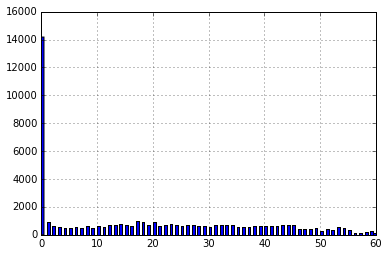

In [450]:
pd.Series(lens).hist(range=(0,60),bins=120)

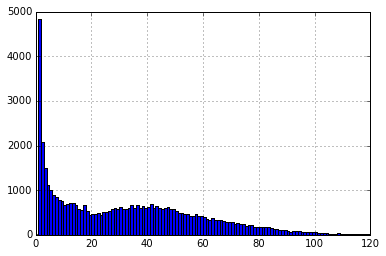

In [452]:
gb.size().hist(range=(0,120),bins=120)

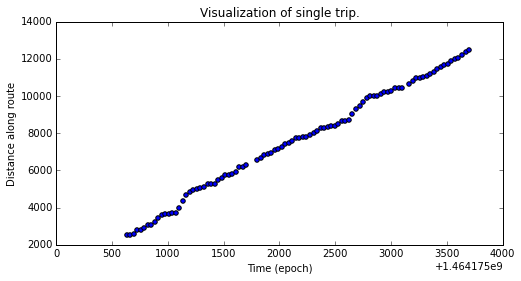

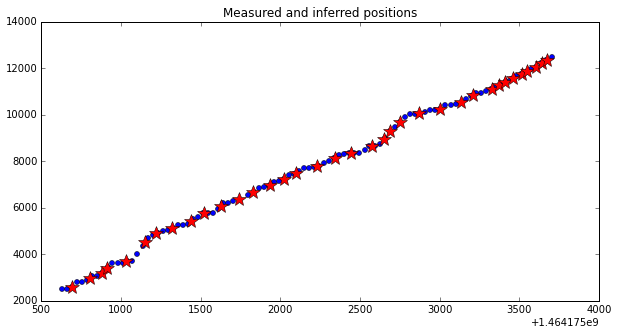

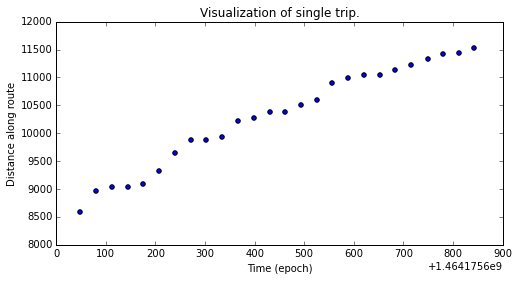

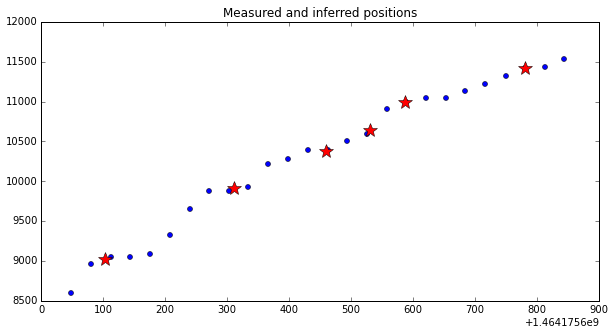

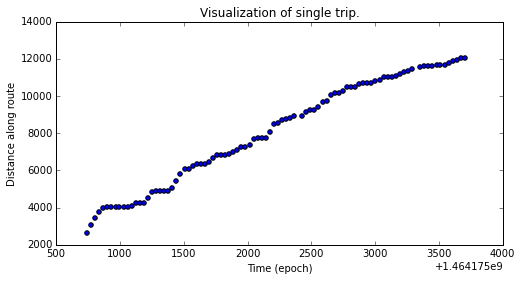

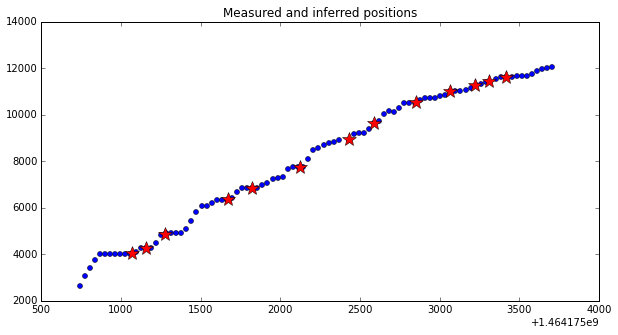

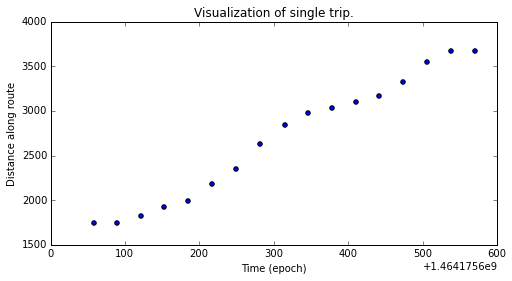

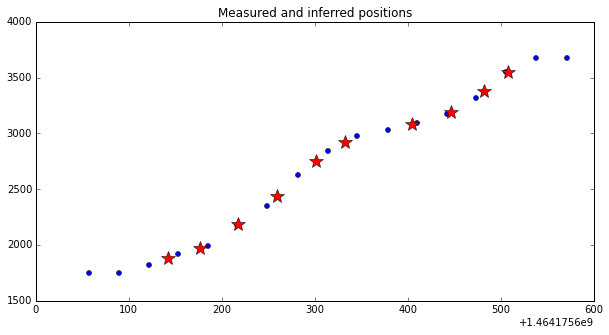

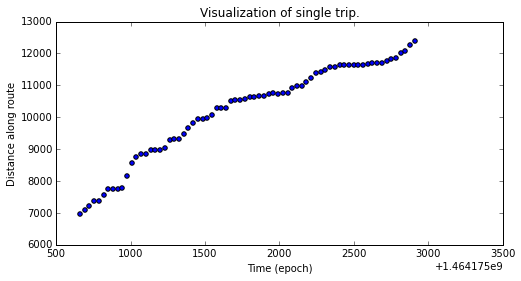

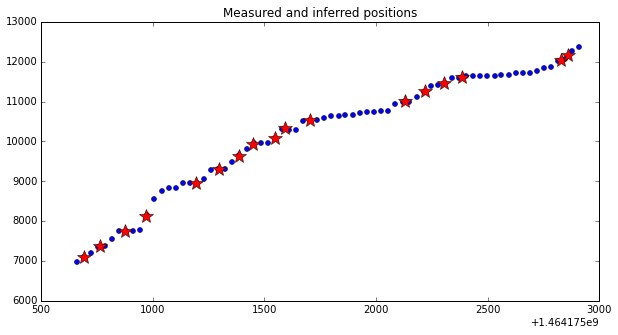

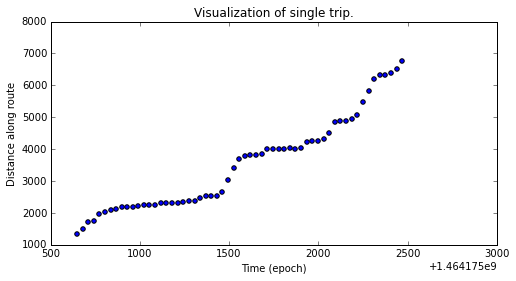

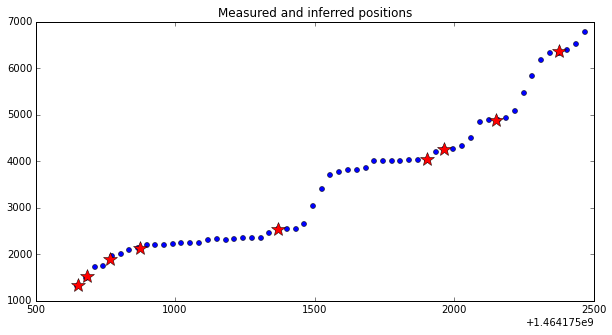

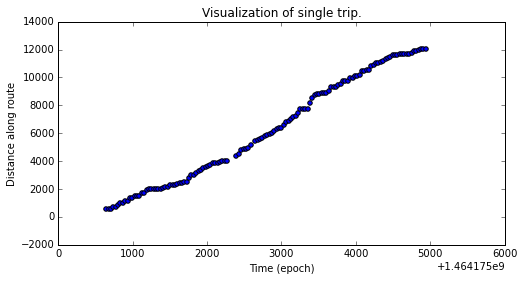

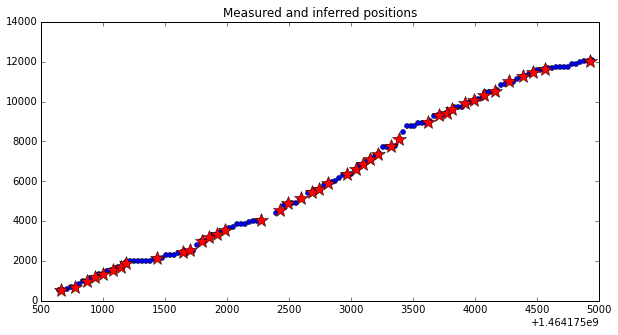

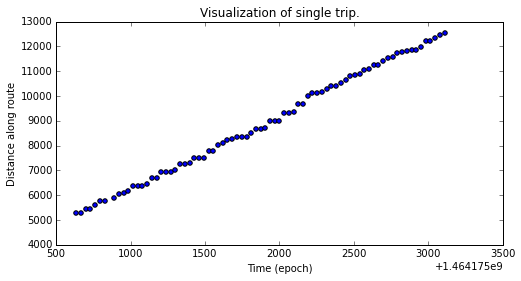

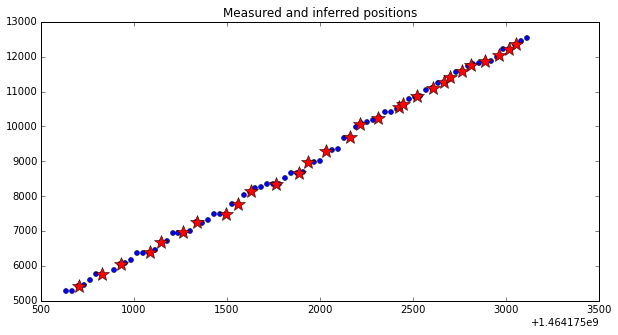

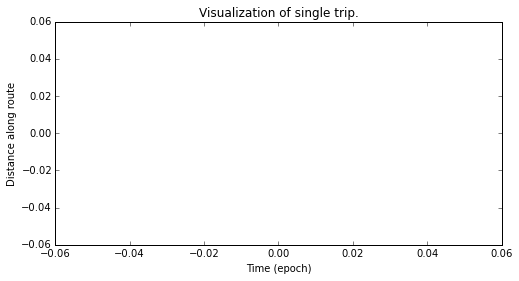

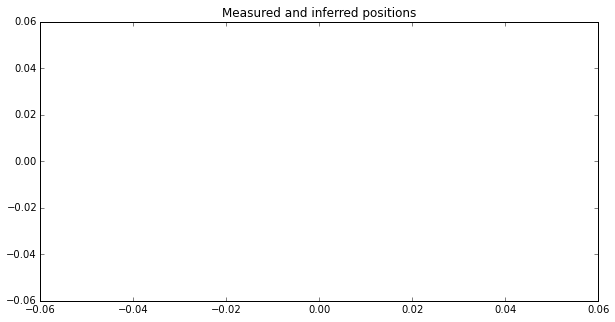

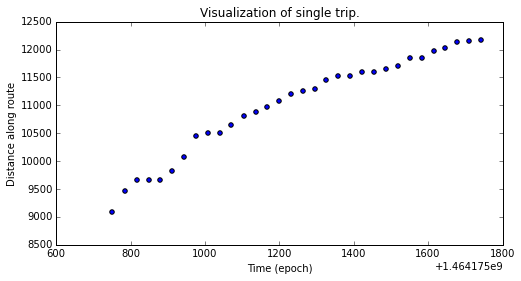

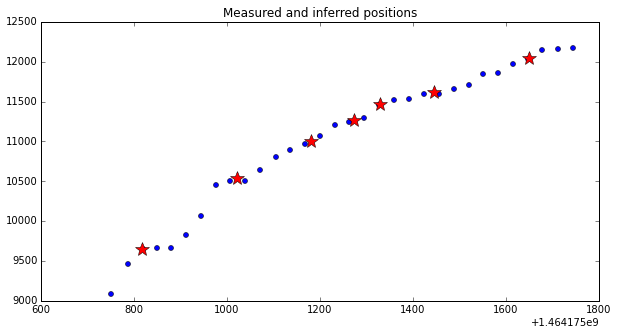

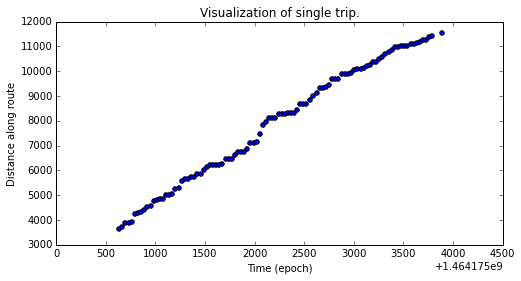

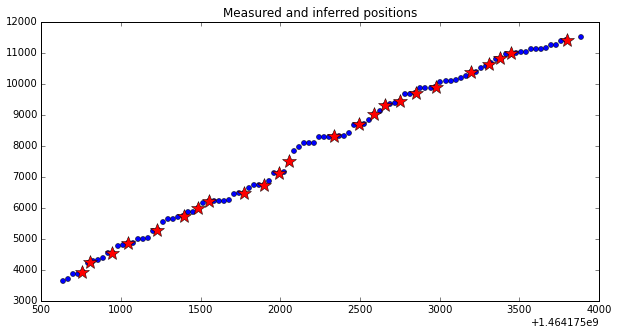

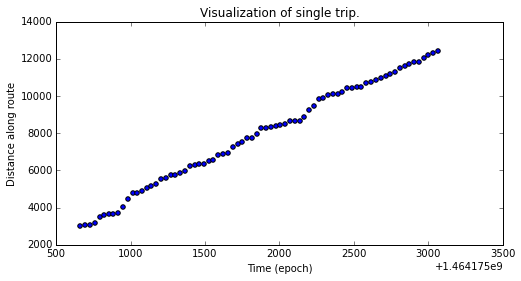

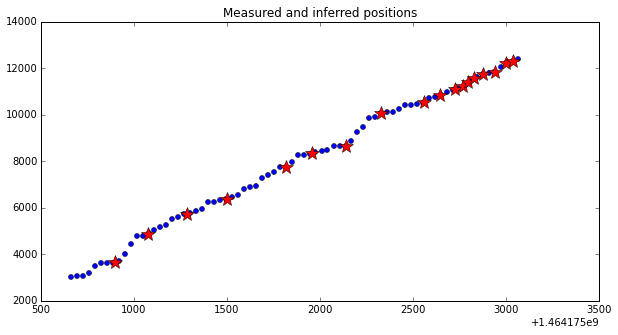

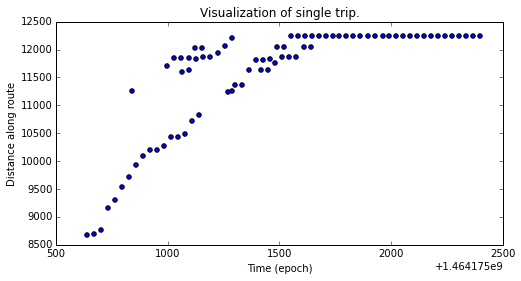

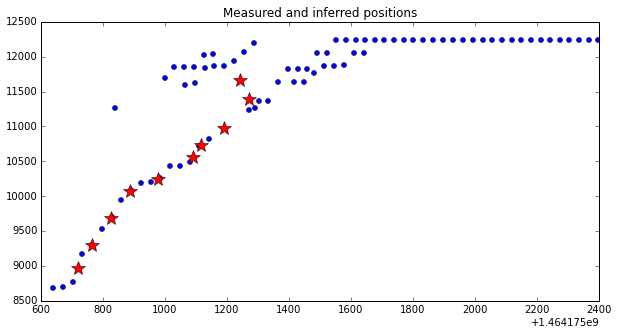

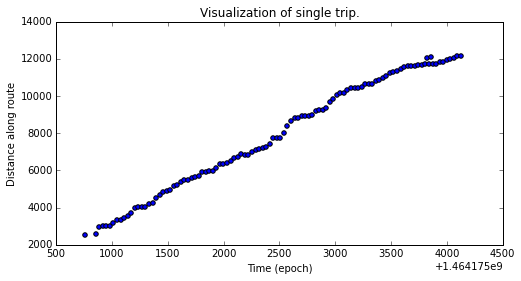

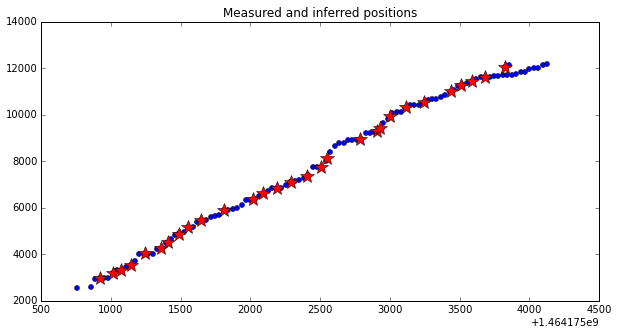

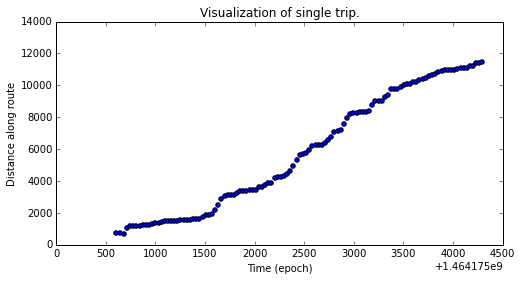

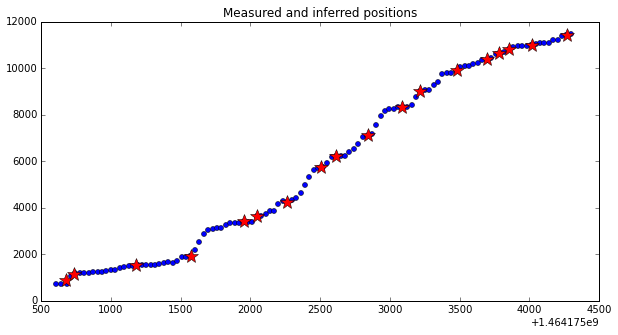

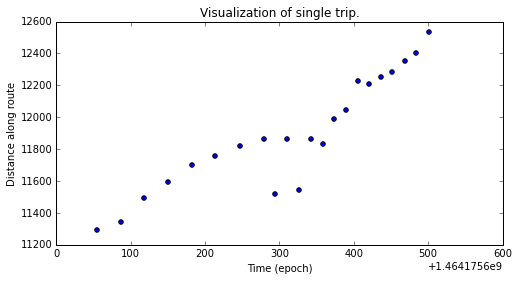

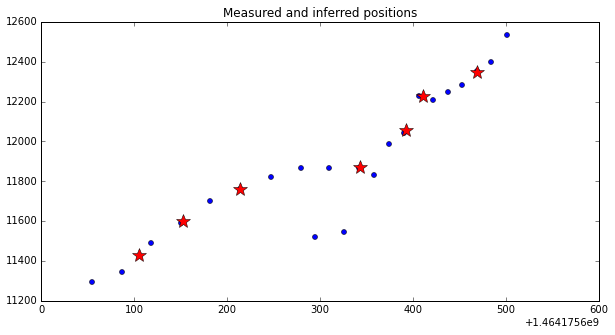

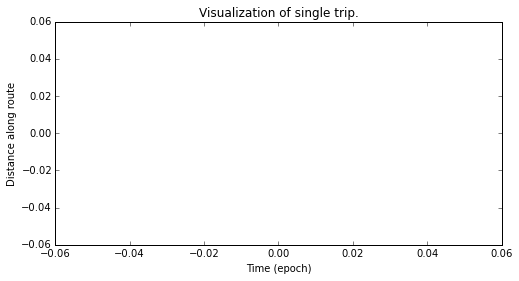

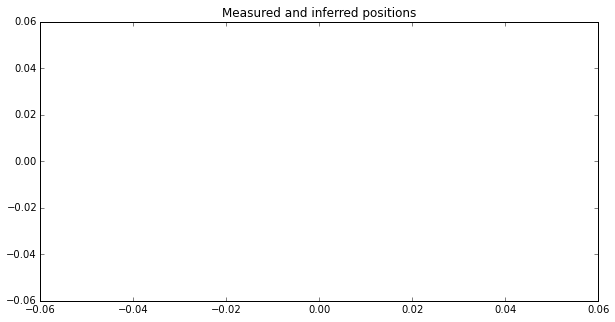

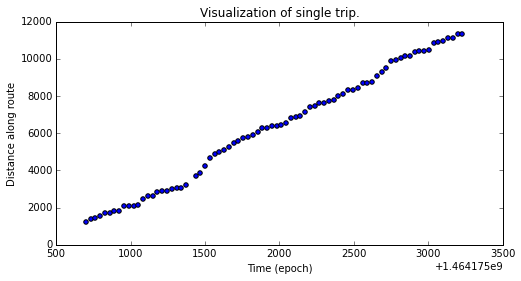

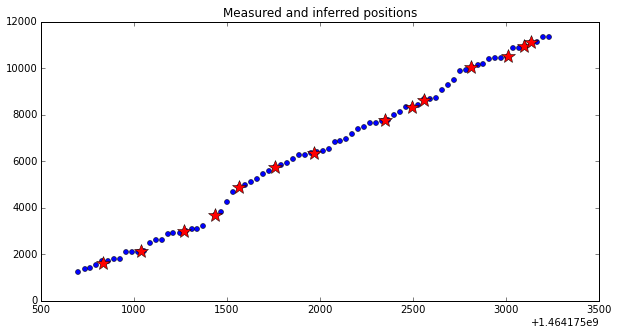

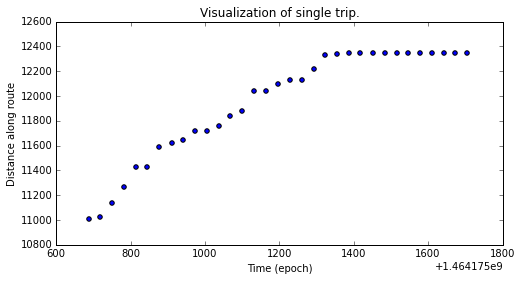

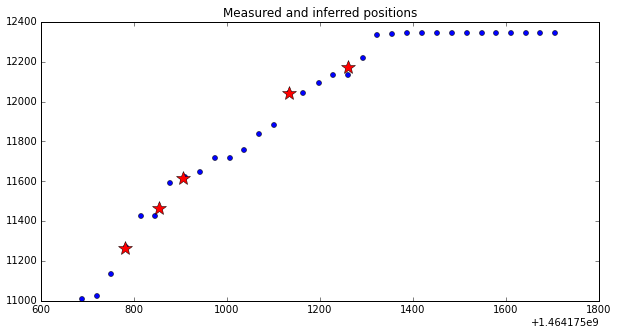

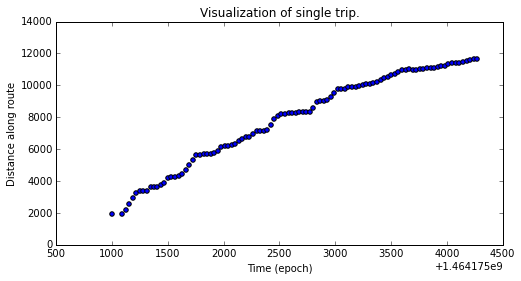

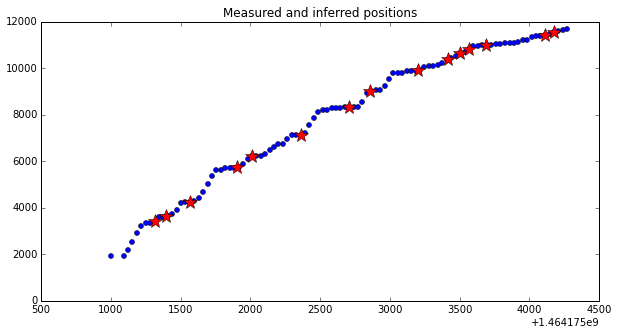

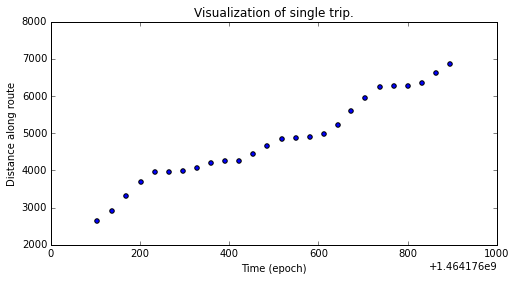

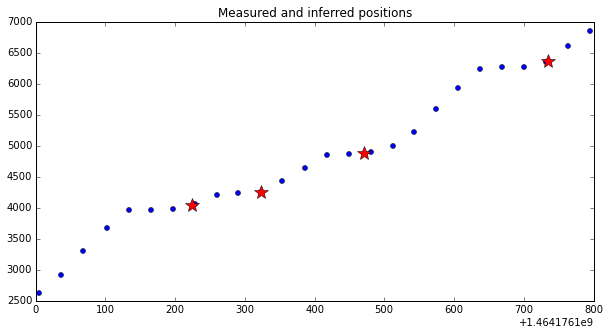

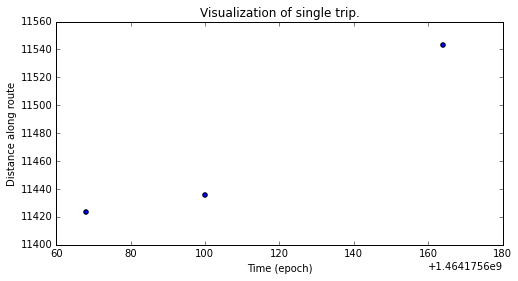

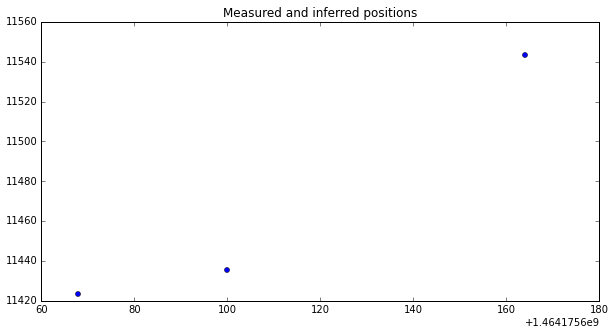

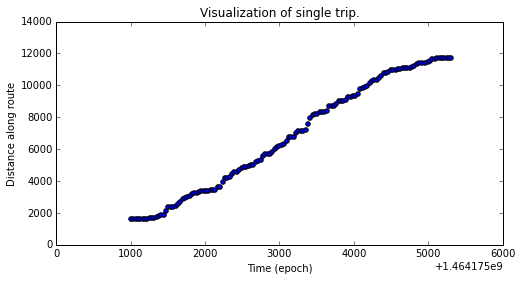

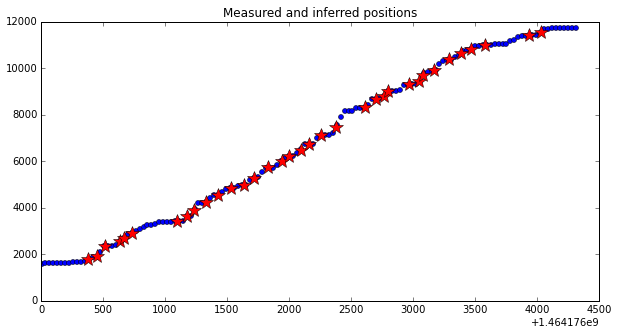

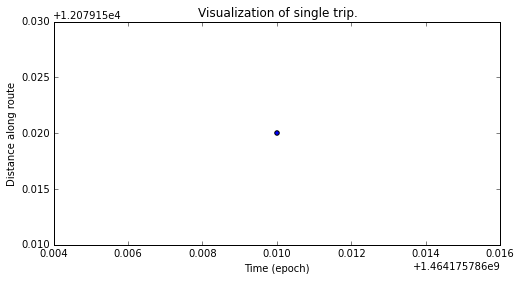

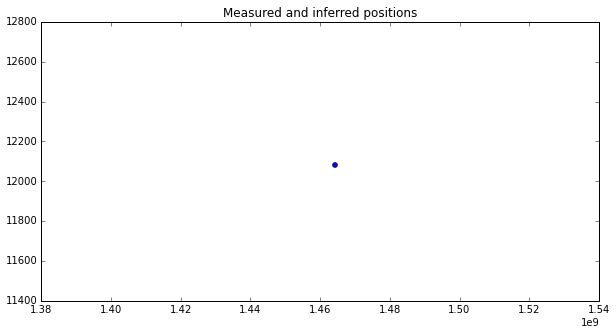

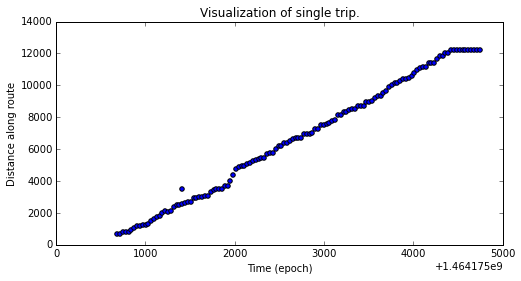

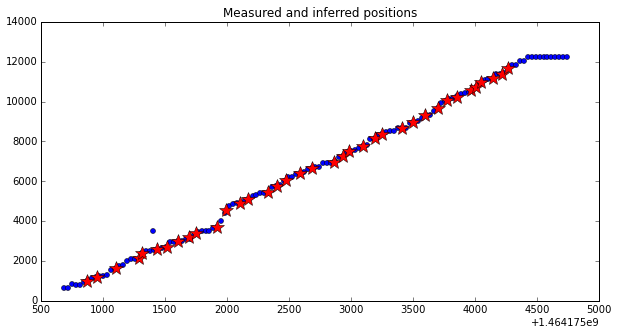

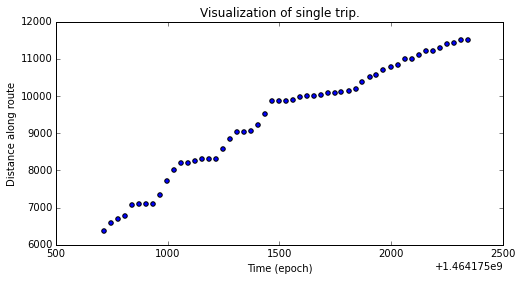

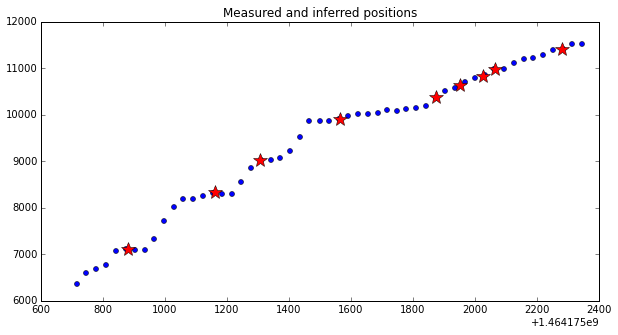

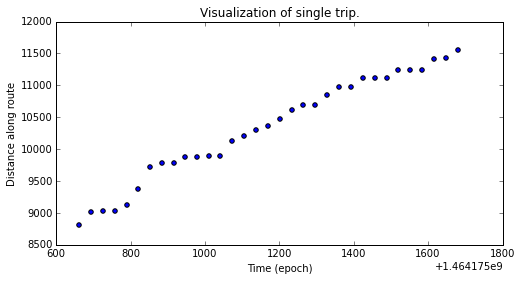

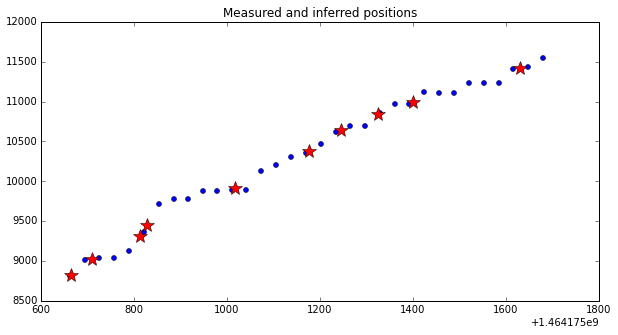

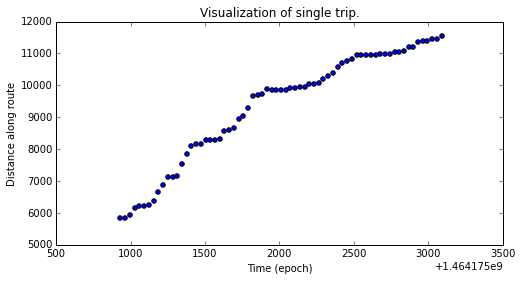

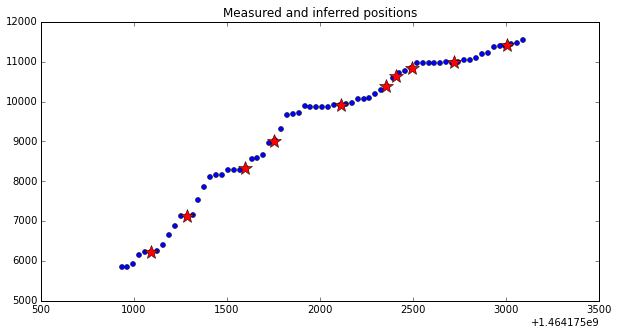

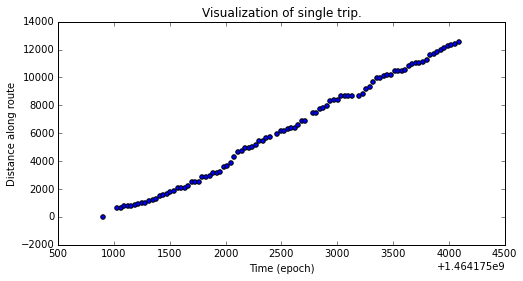

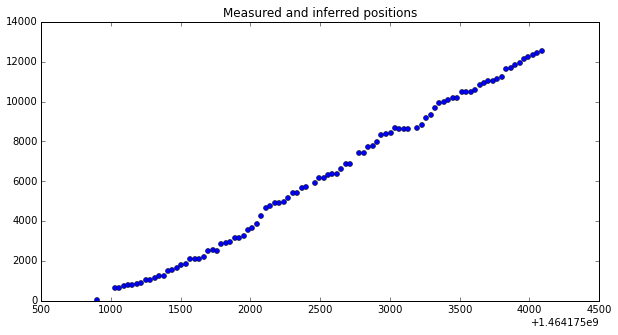

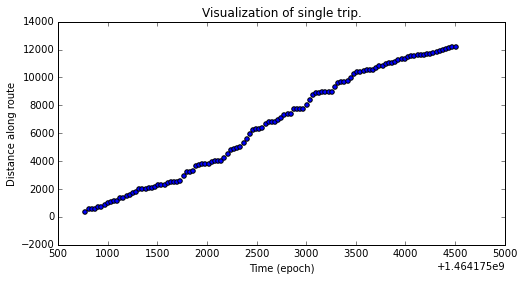

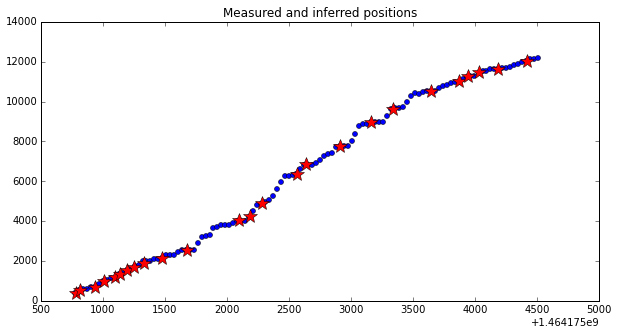

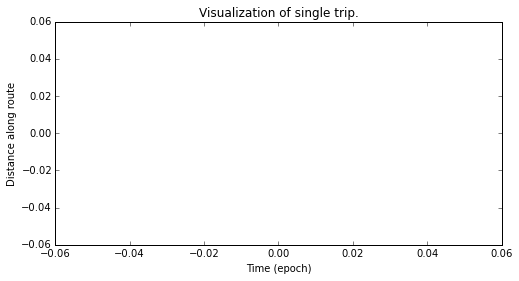

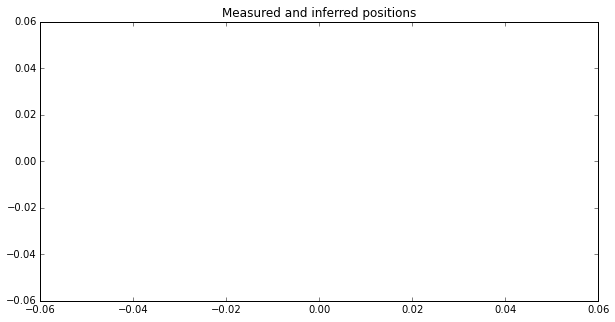

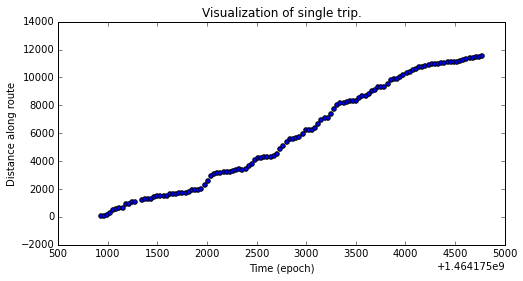

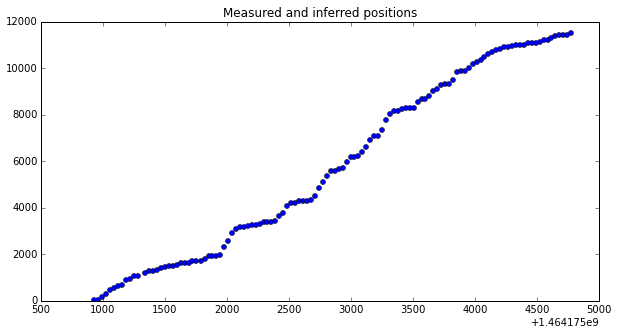

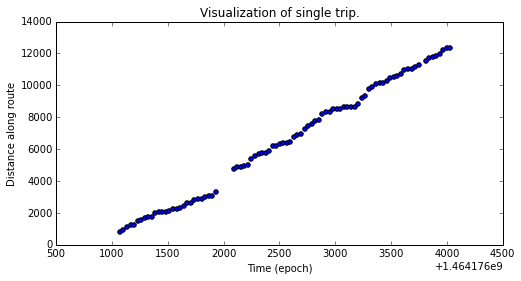

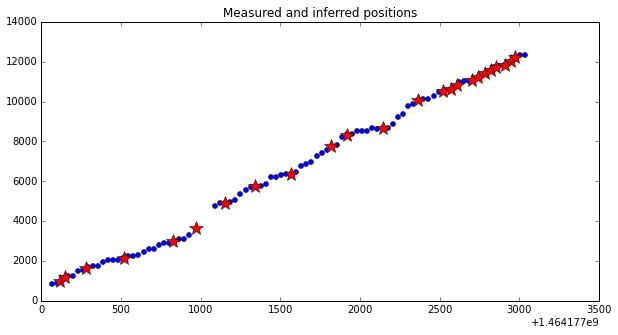

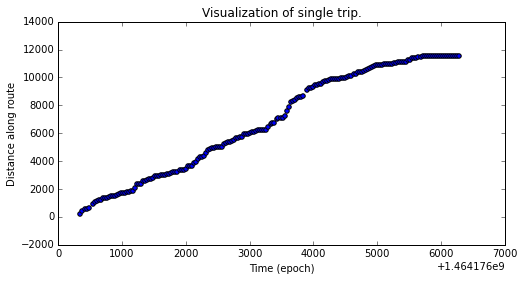

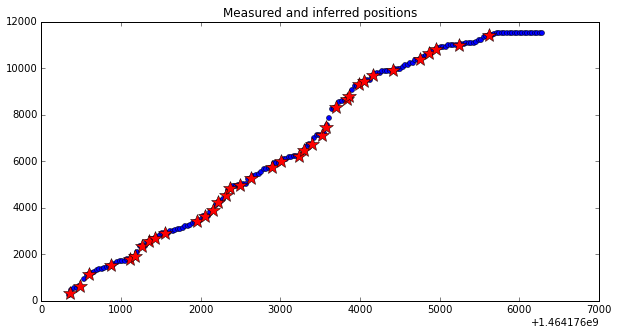

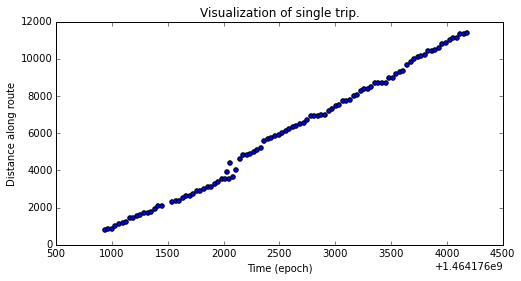

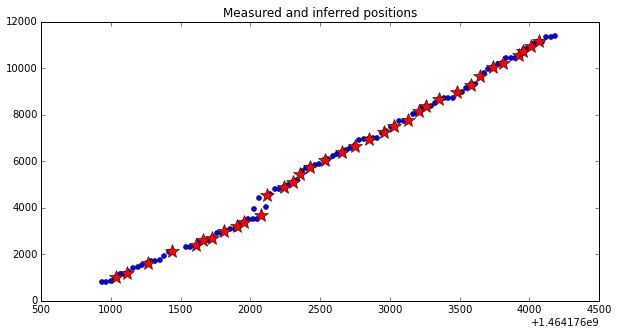

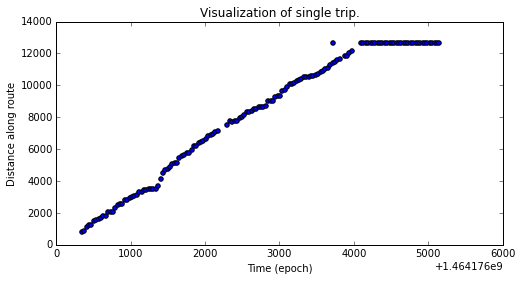

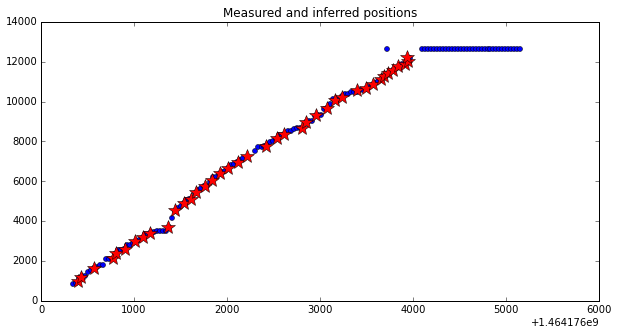

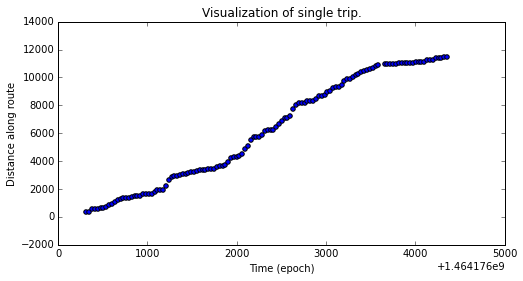

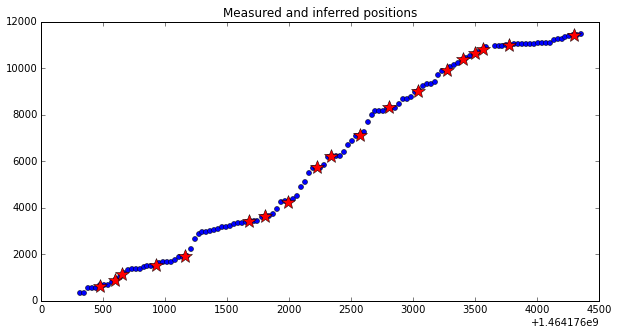

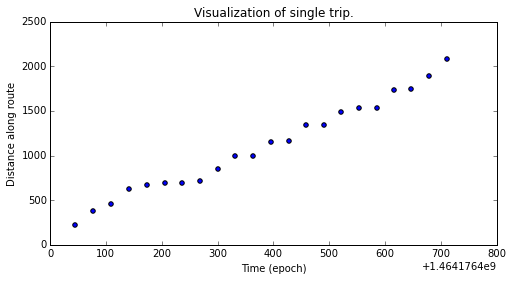

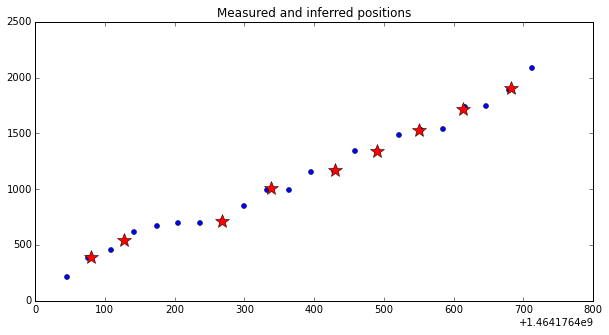

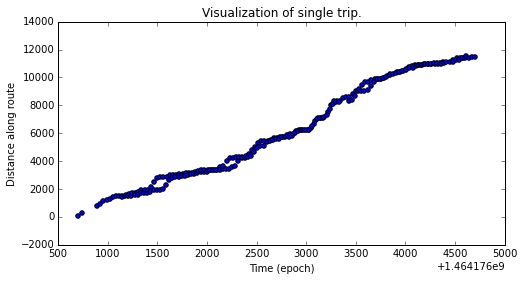

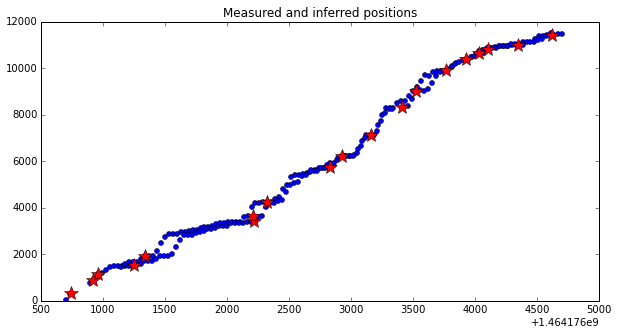

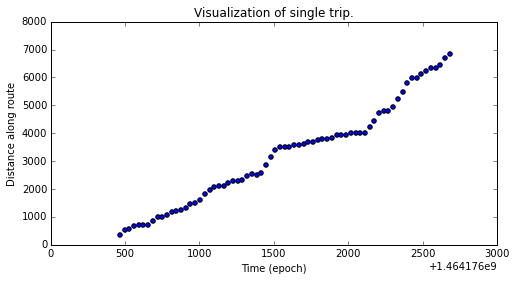

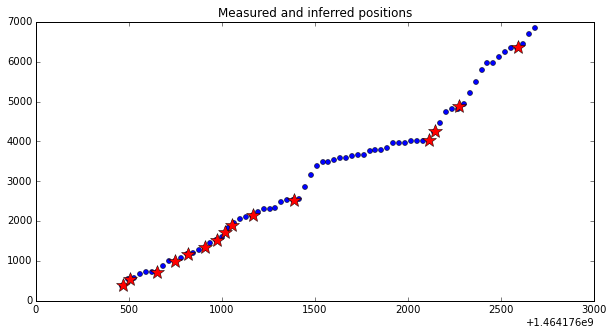

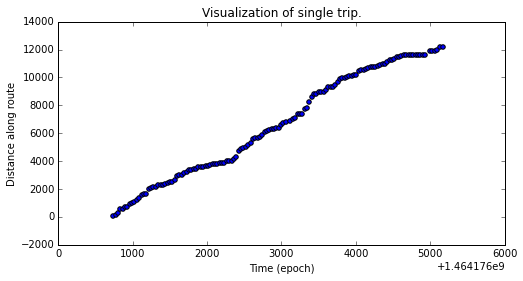

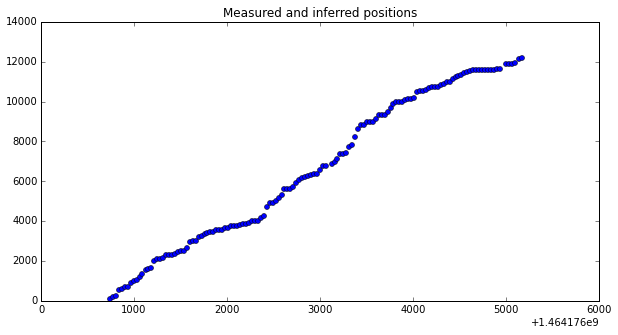

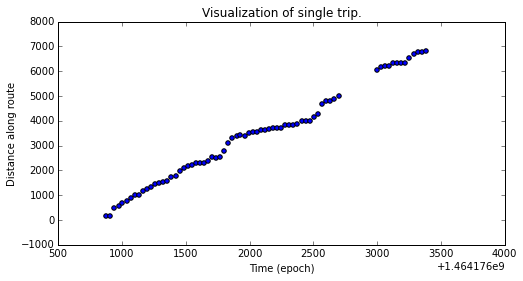

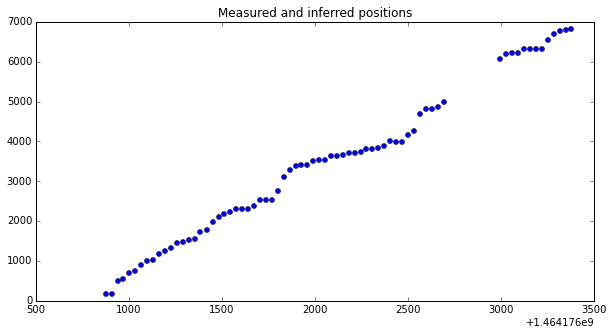

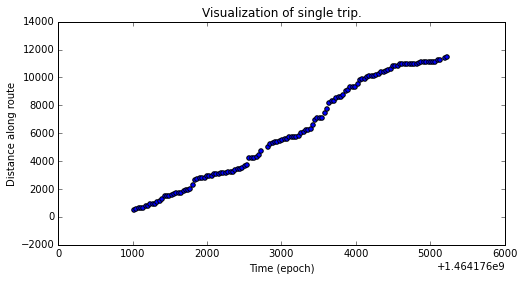

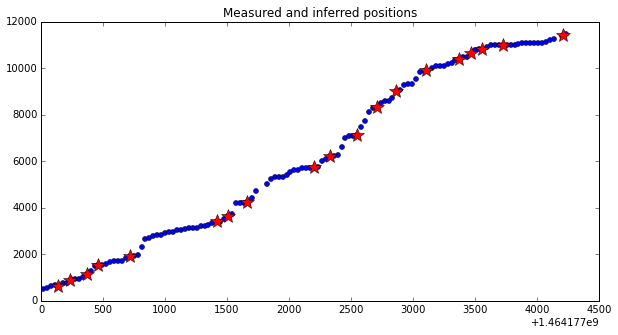

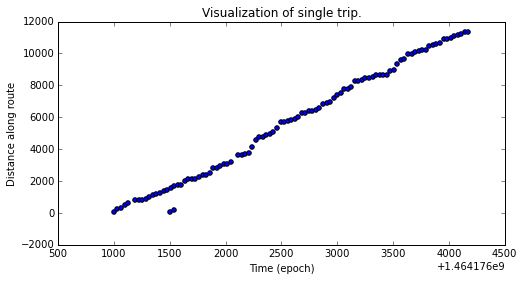

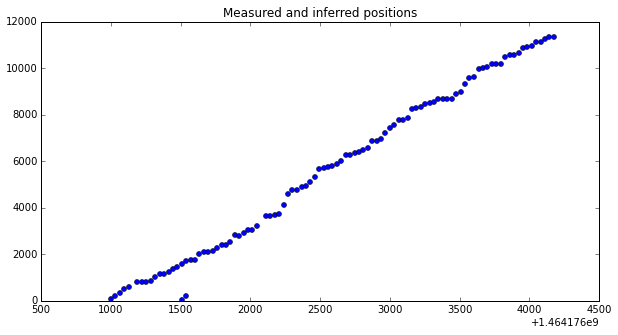

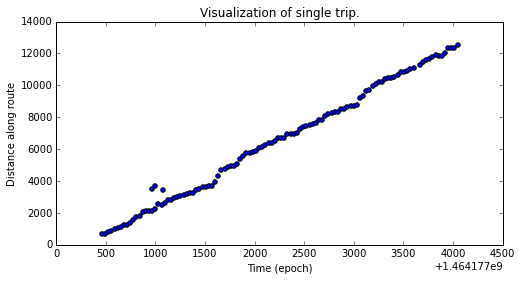

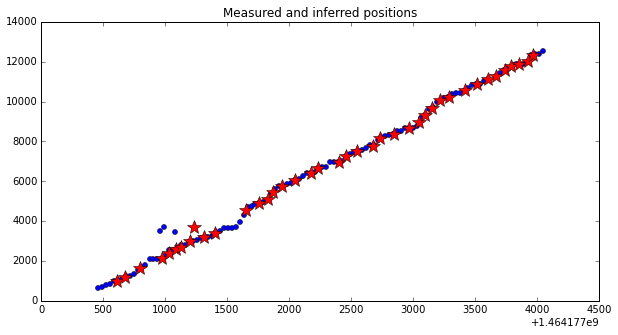

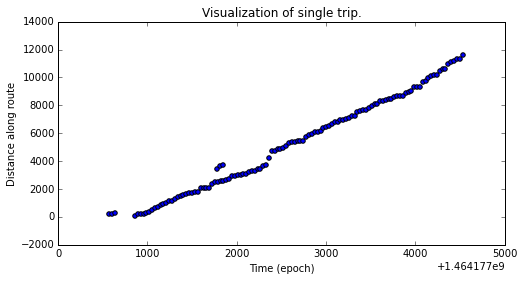

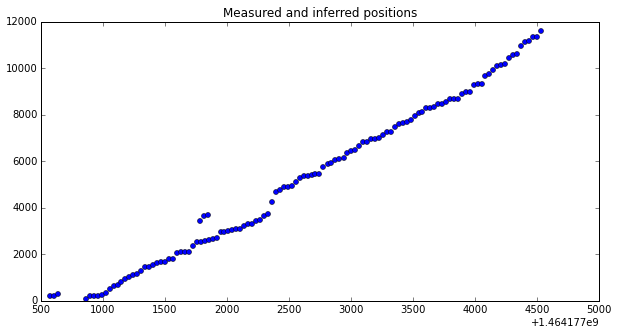

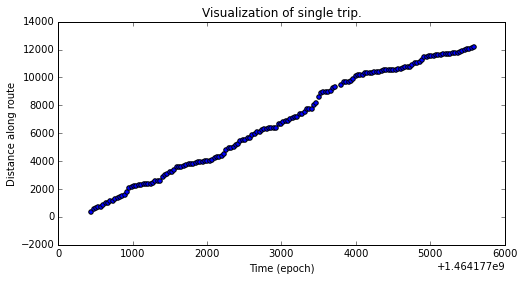

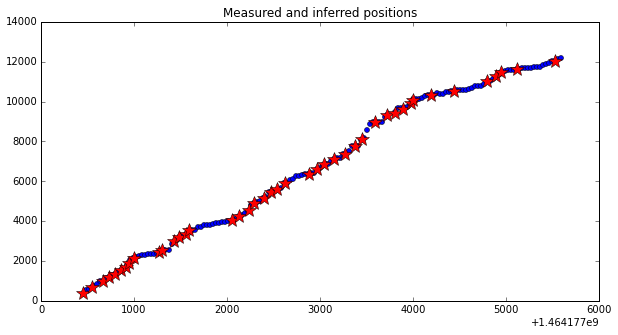

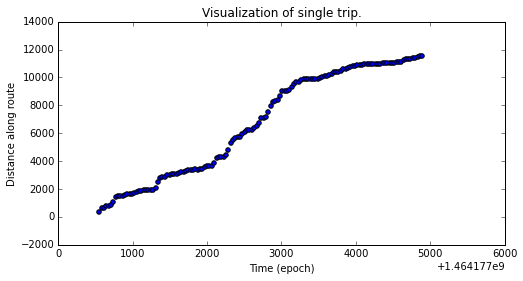

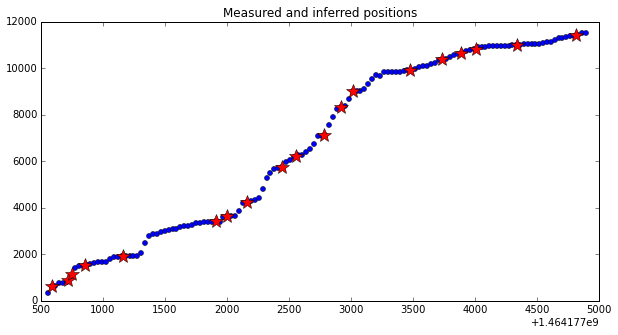

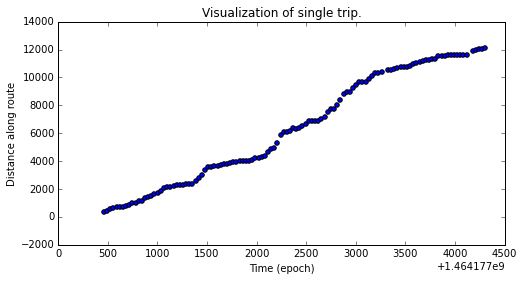

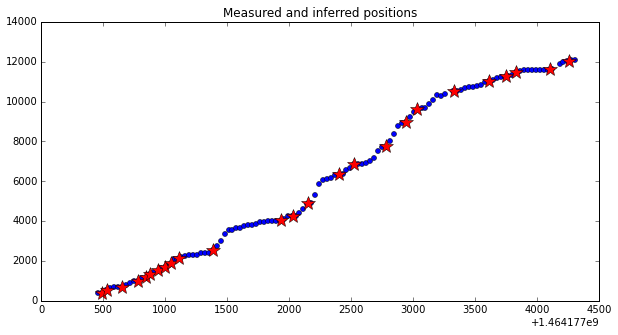

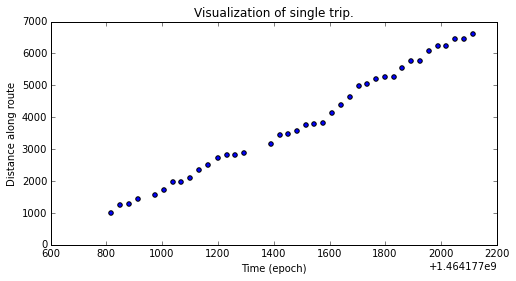

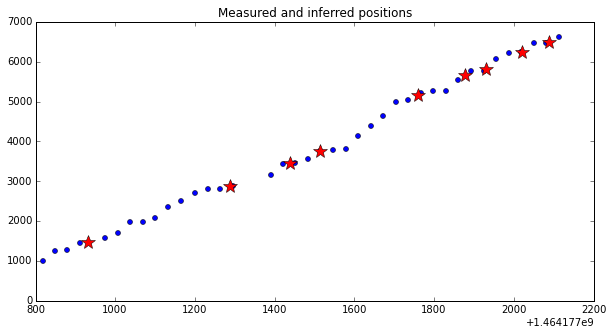

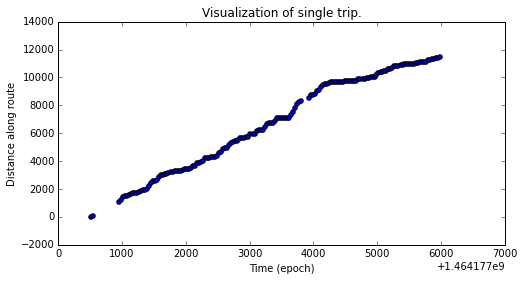

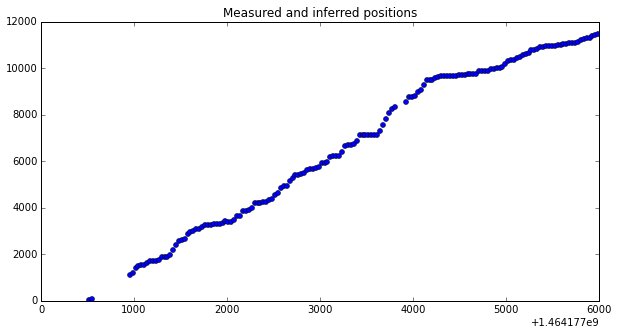

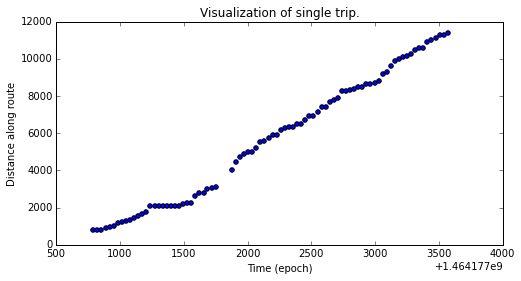

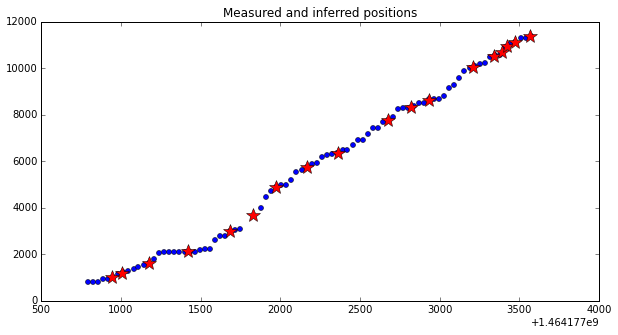

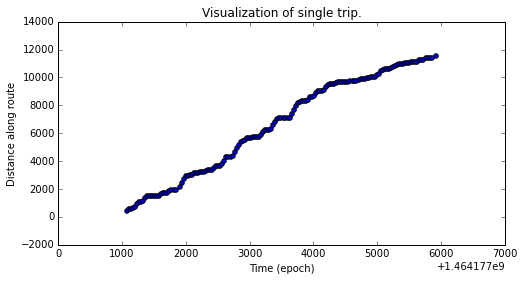

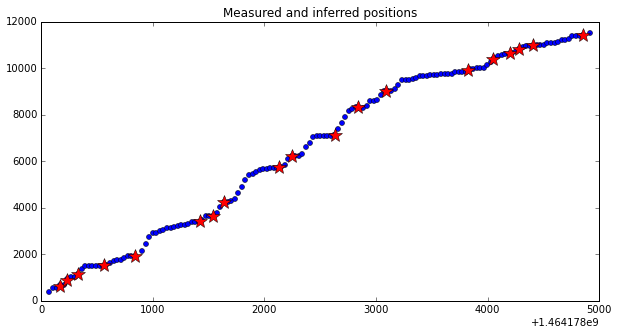

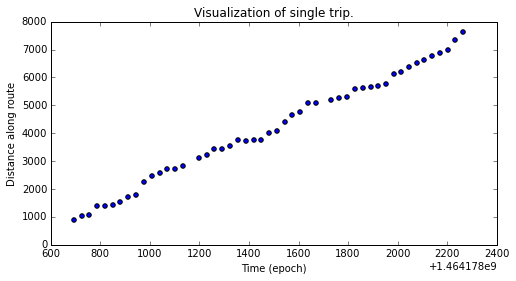

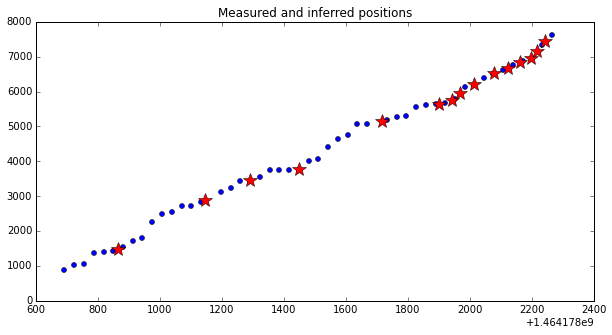

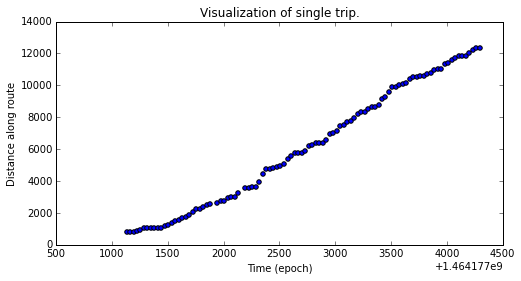

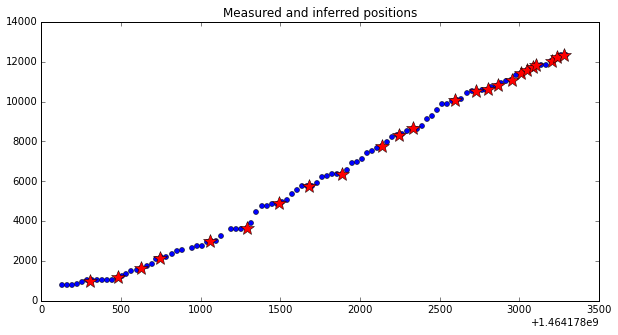

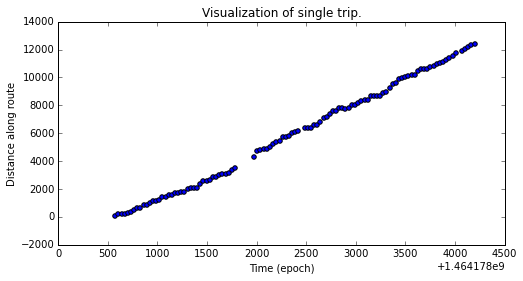

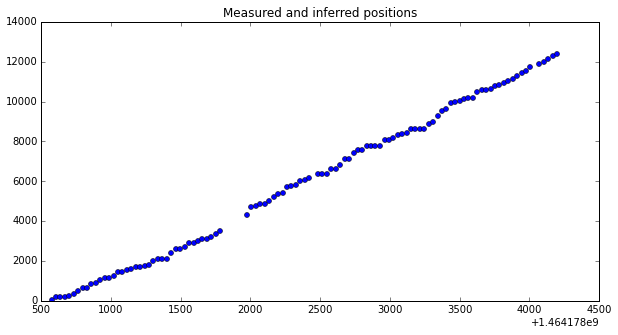

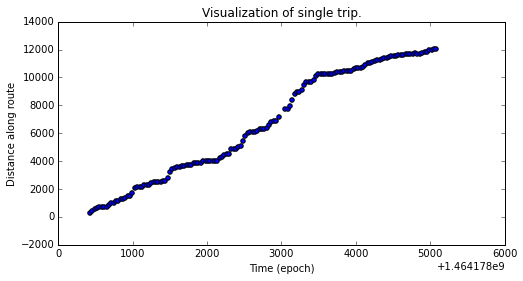

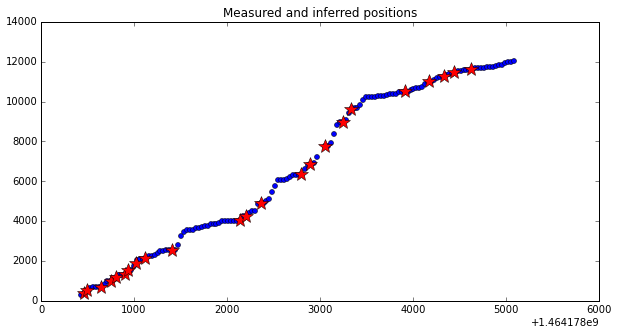

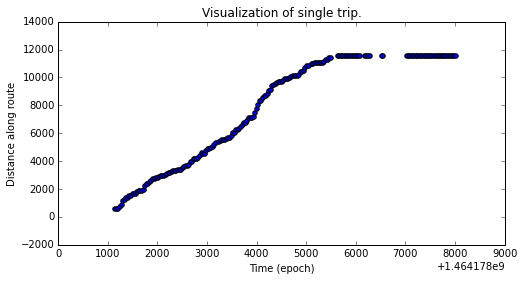

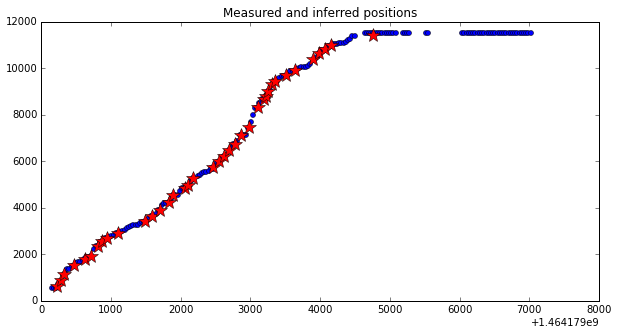

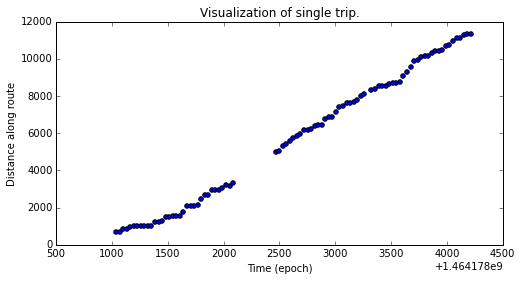

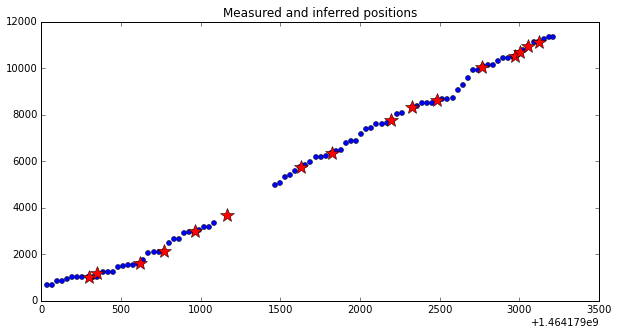

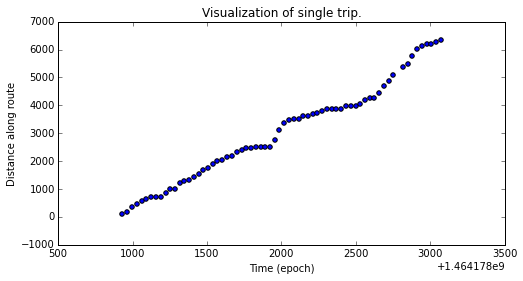

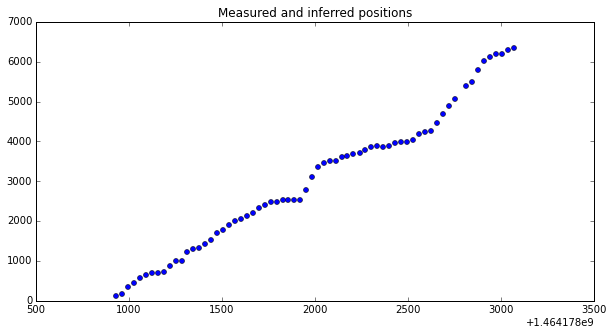

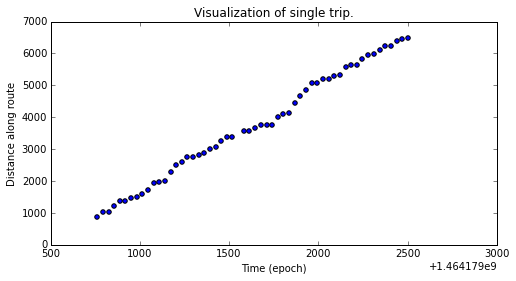

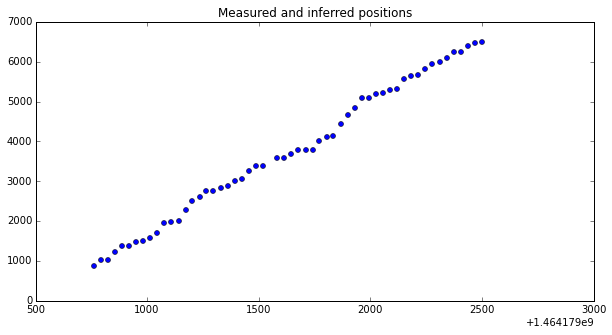

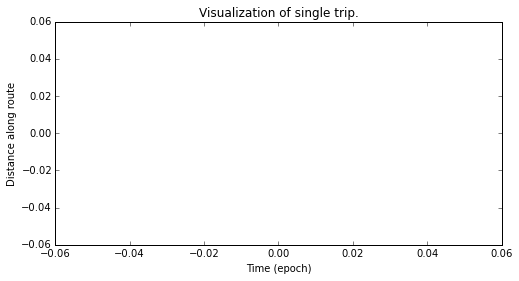

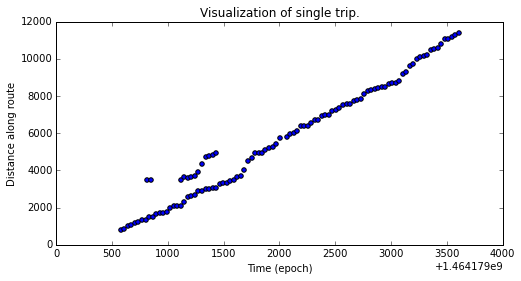

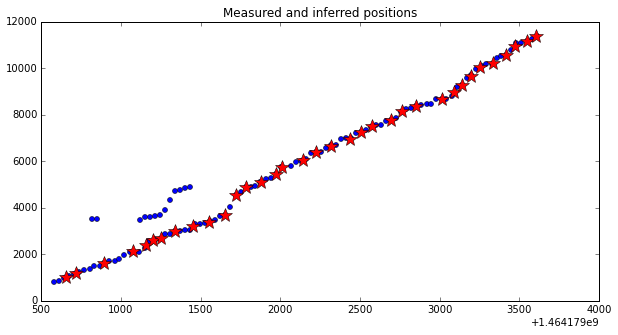

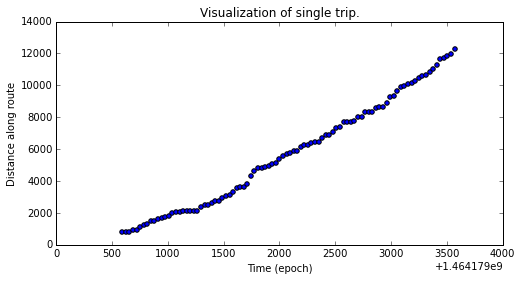

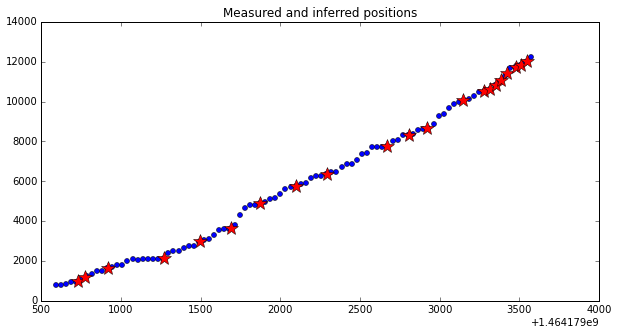

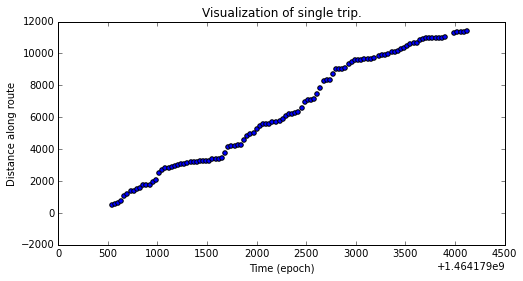

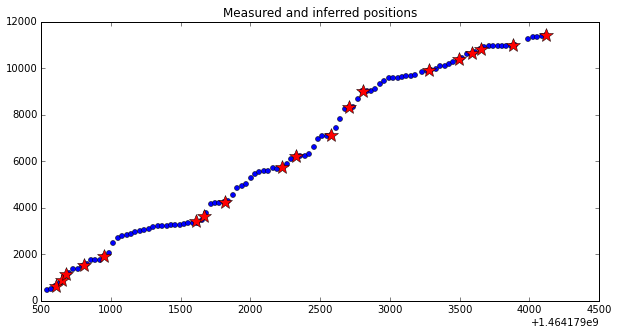

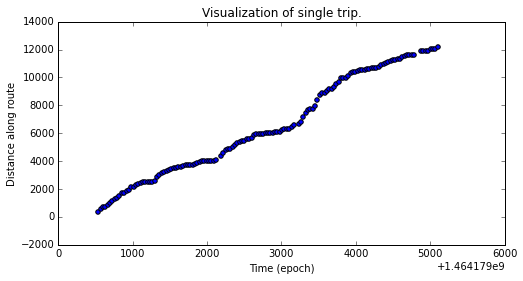

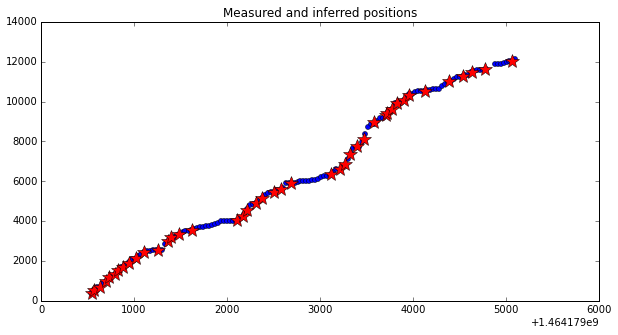

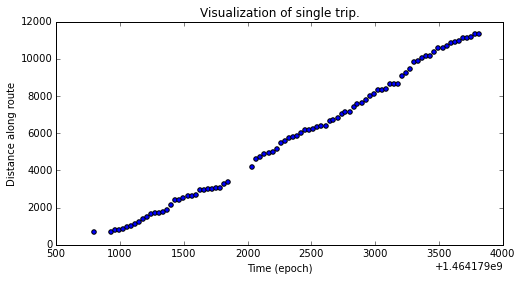

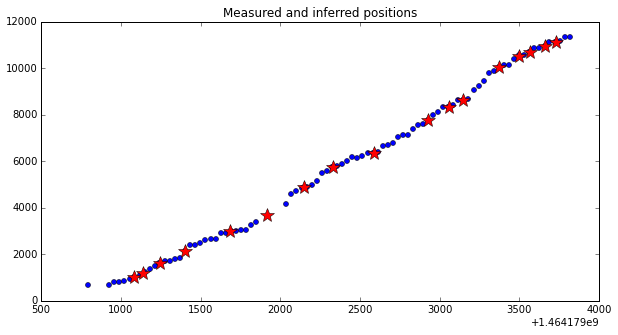

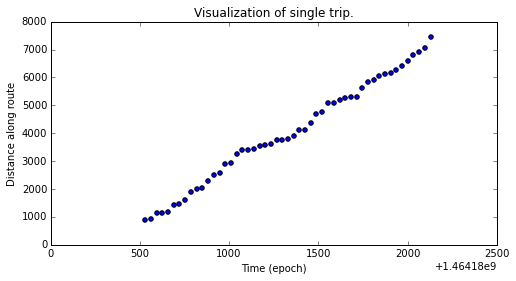

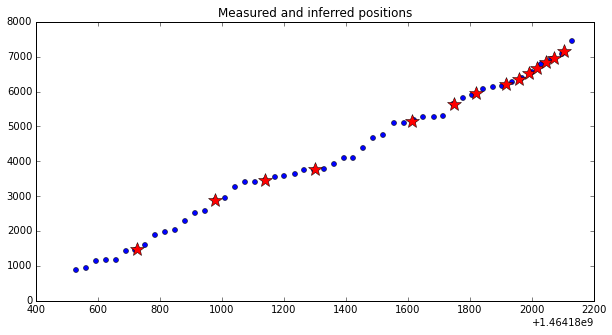

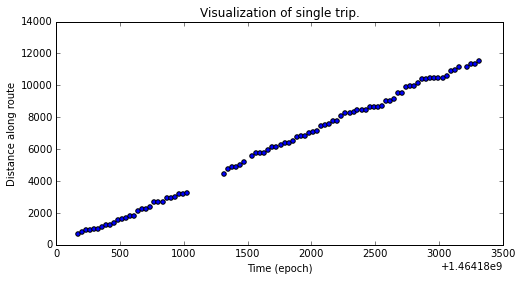

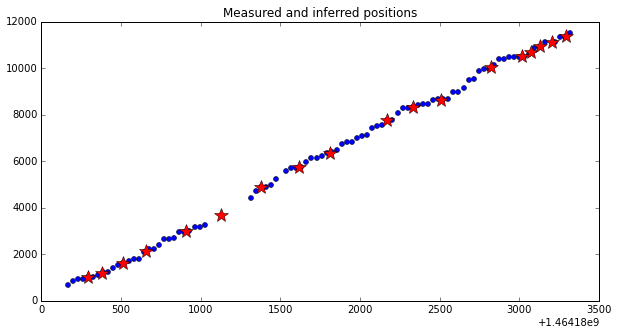

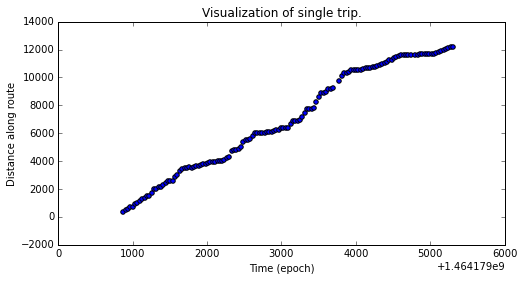

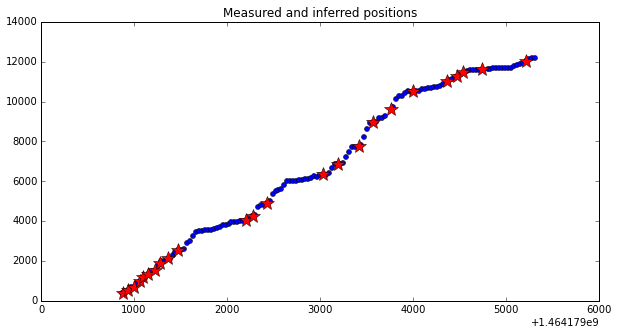

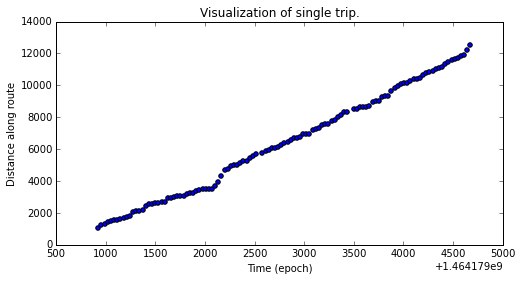

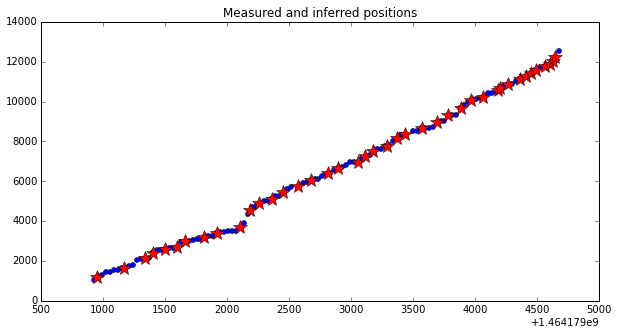

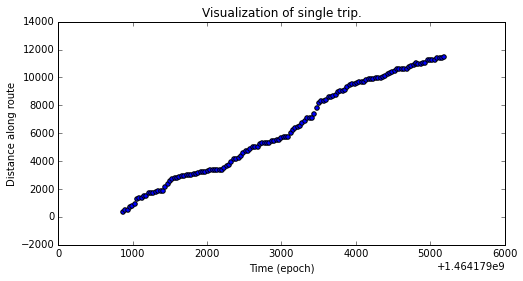

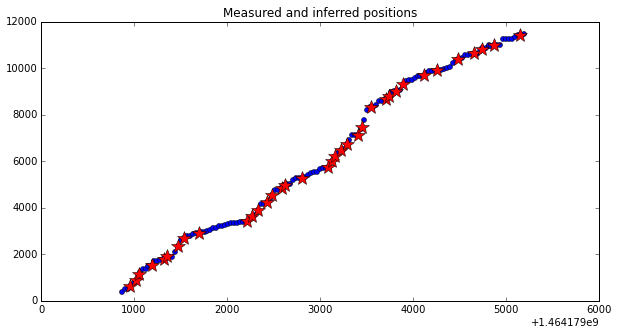

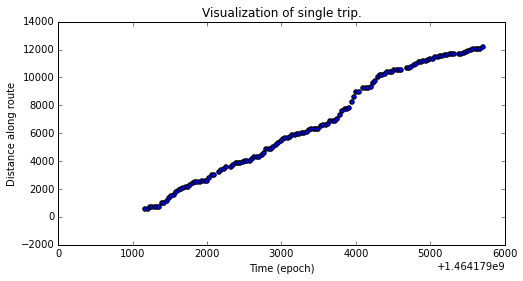

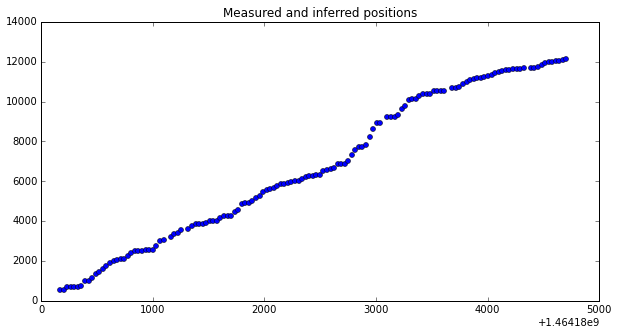

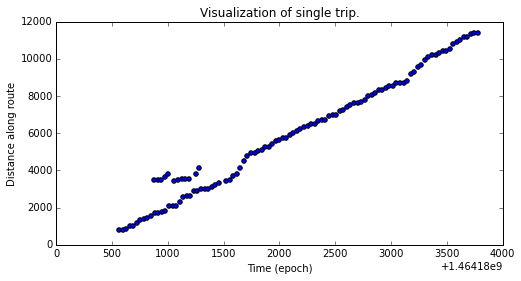

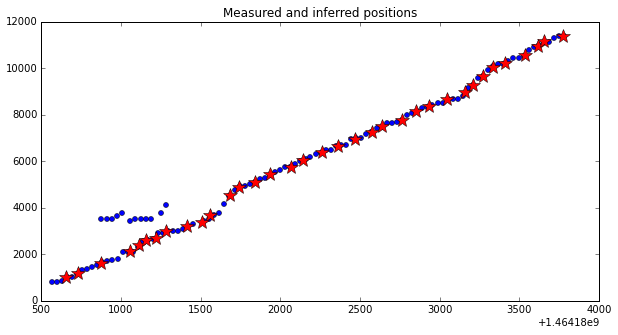

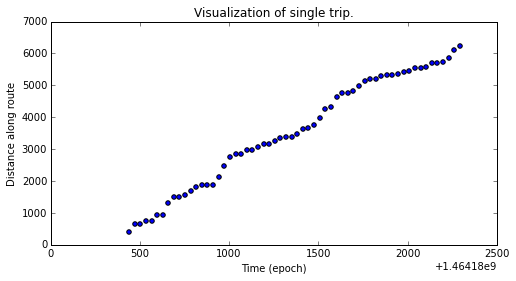

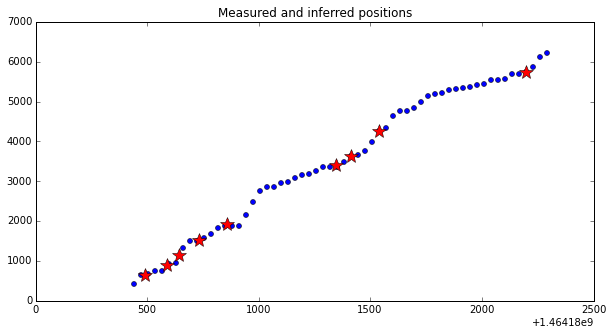

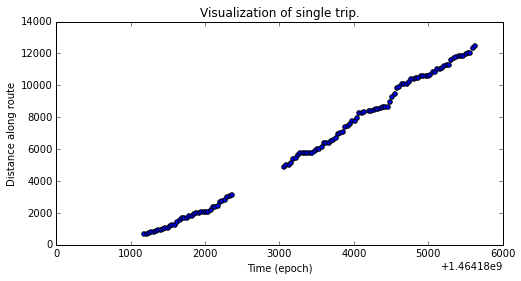

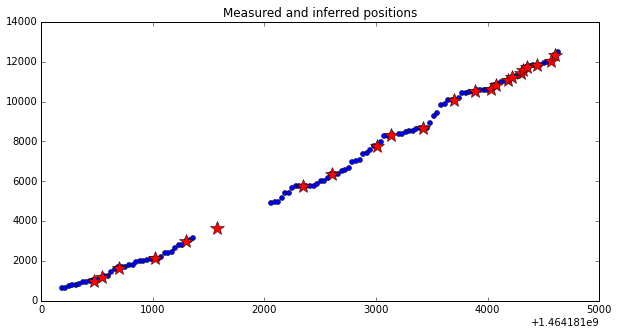

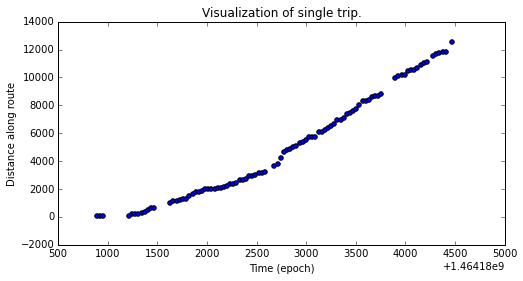

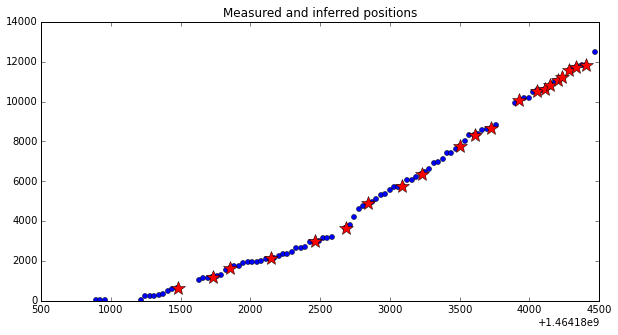

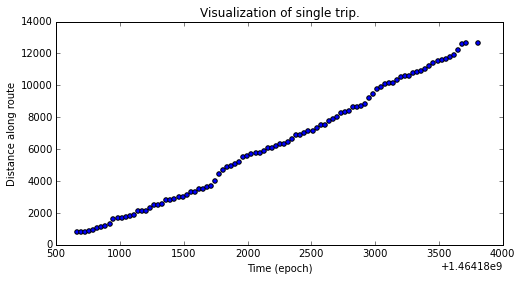

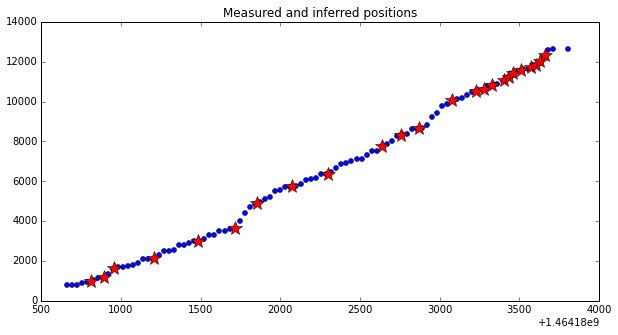

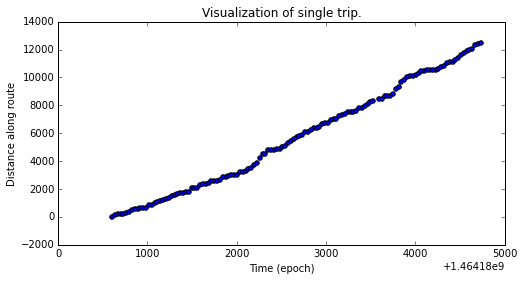

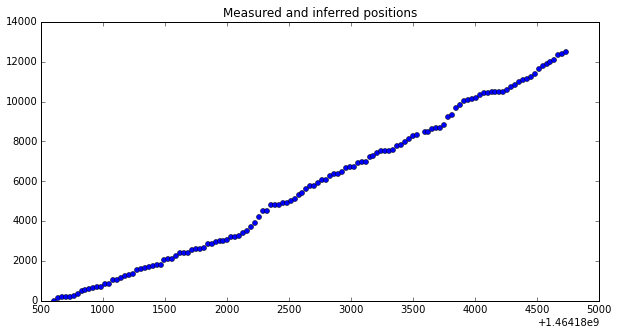

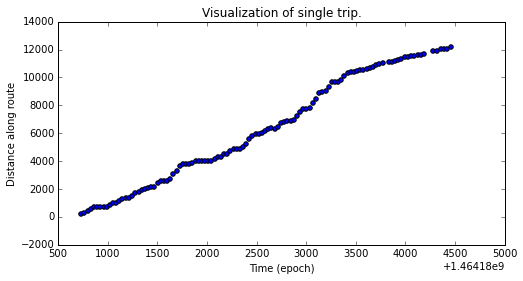

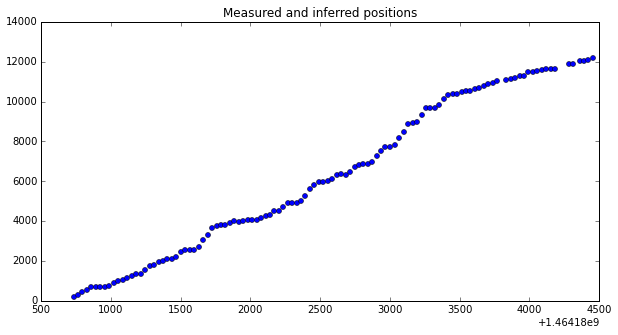

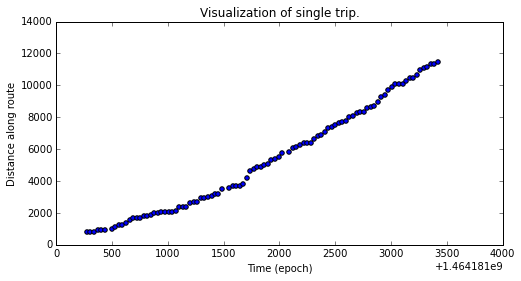

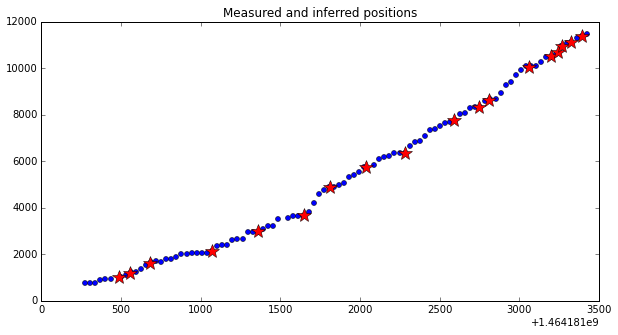

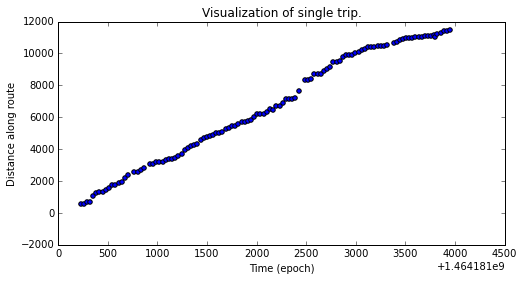

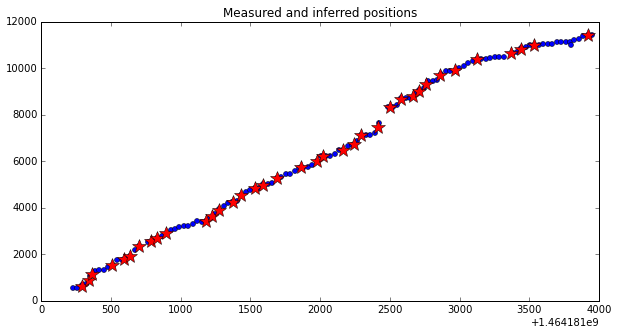

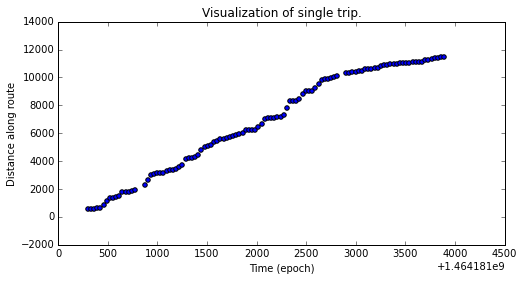

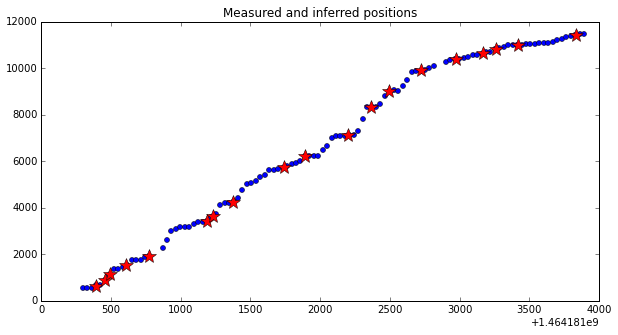

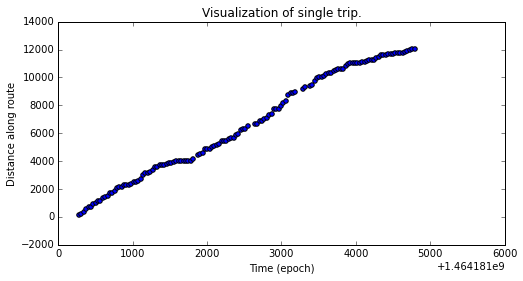

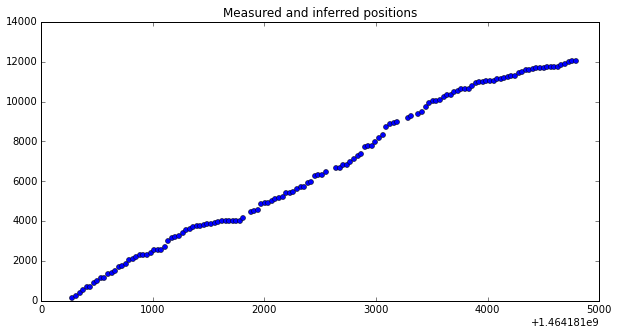

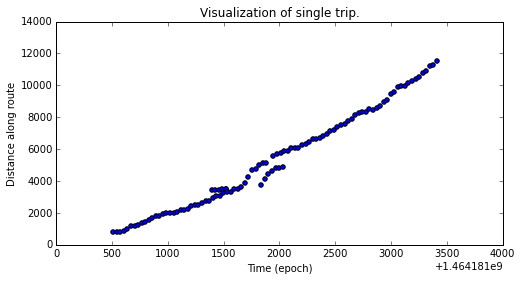

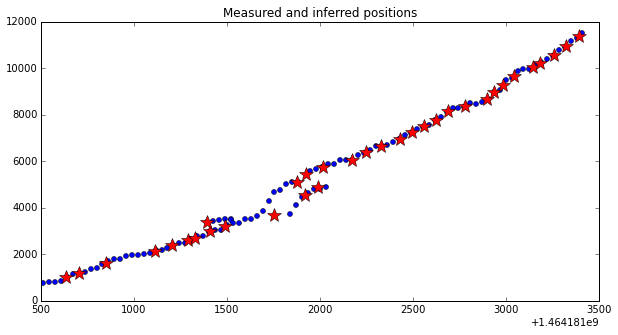

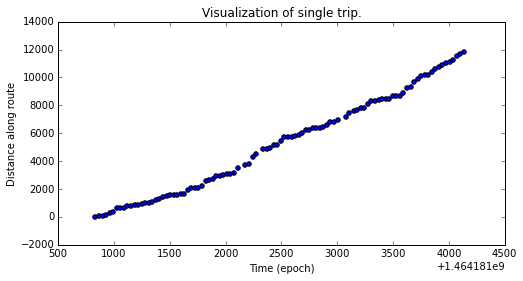

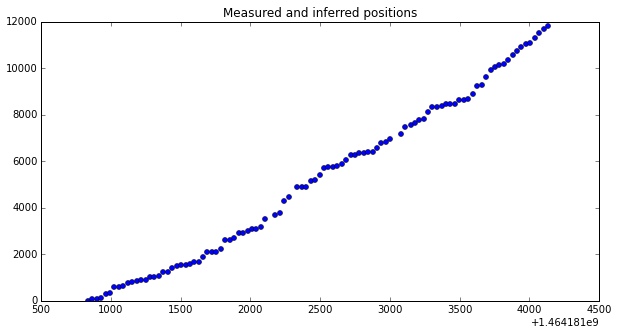

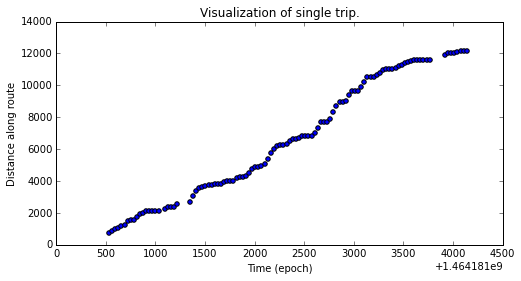

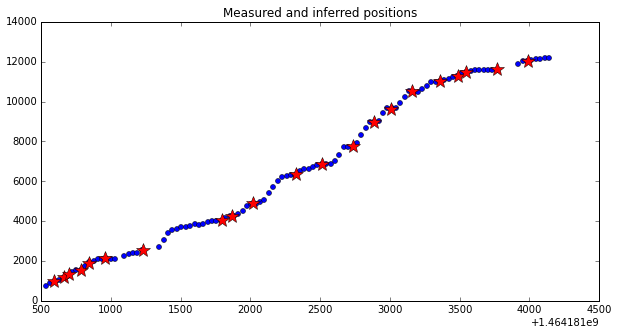

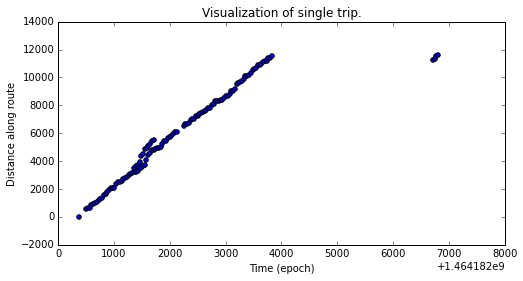

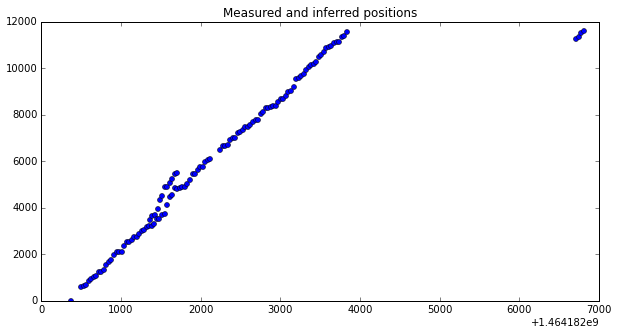

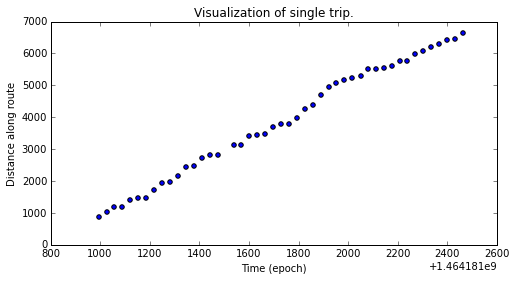

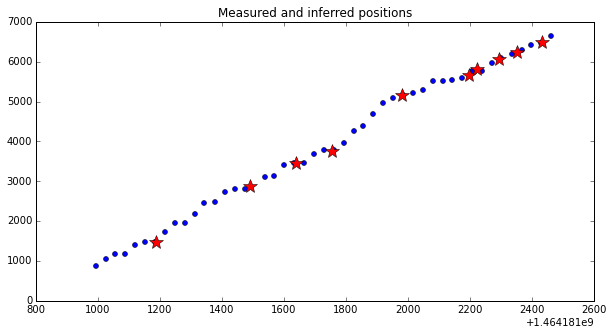

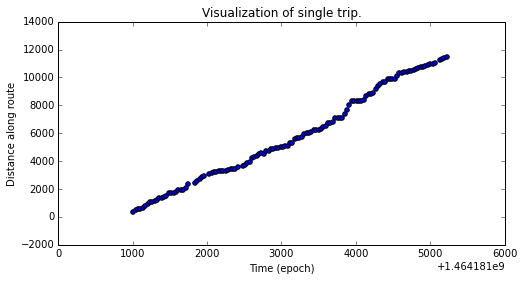

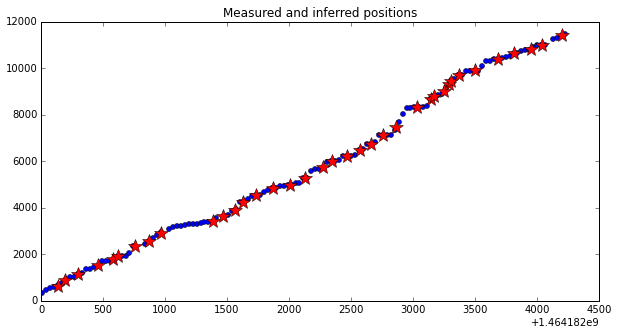

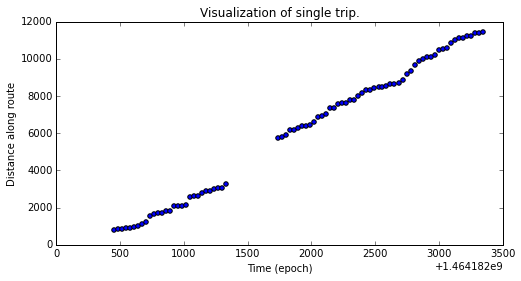

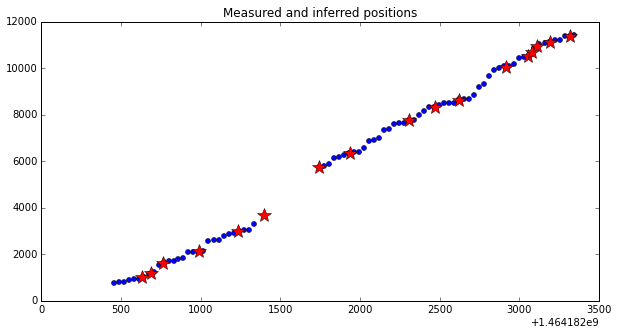

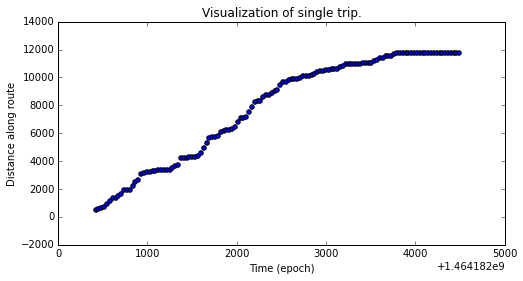

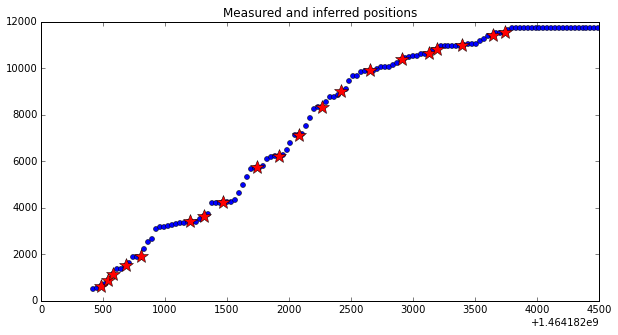

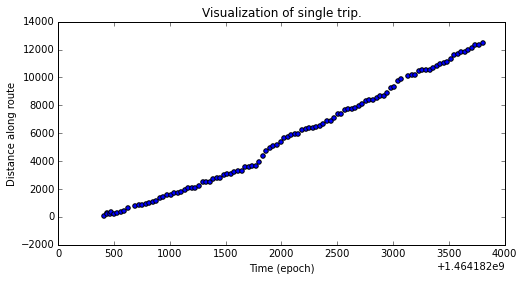

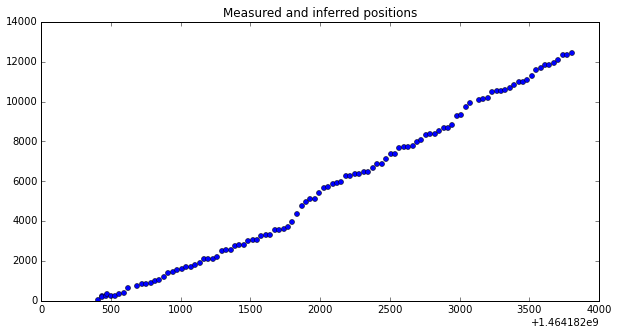

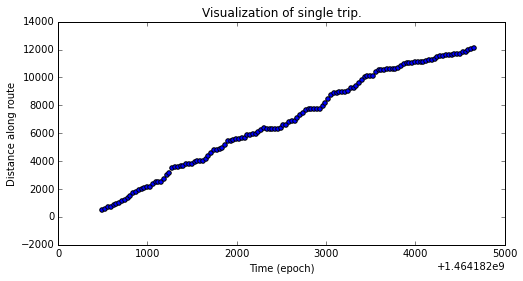

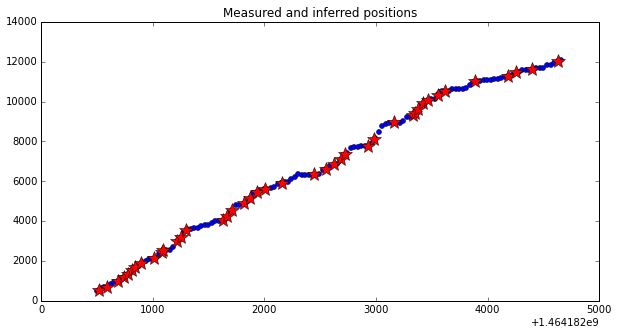

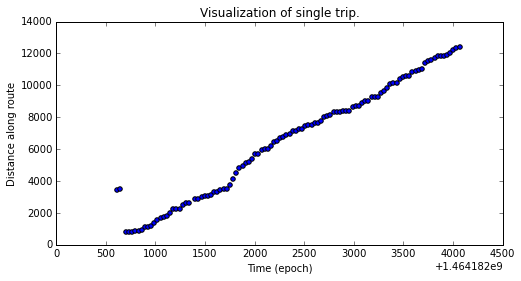

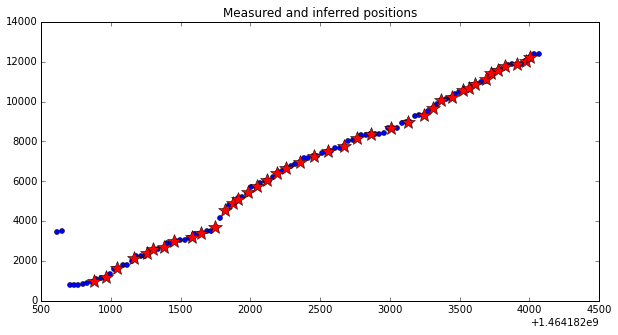

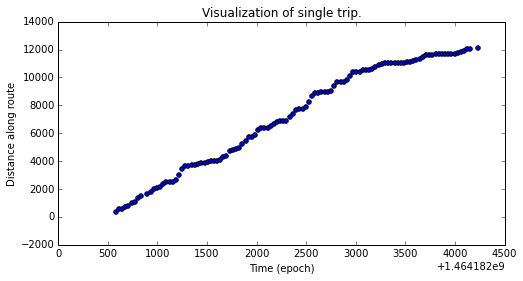

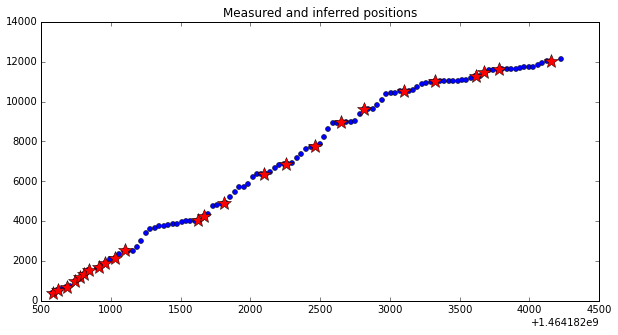

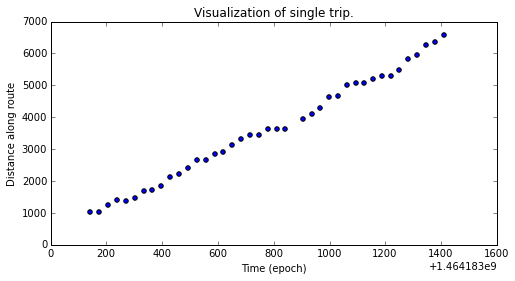

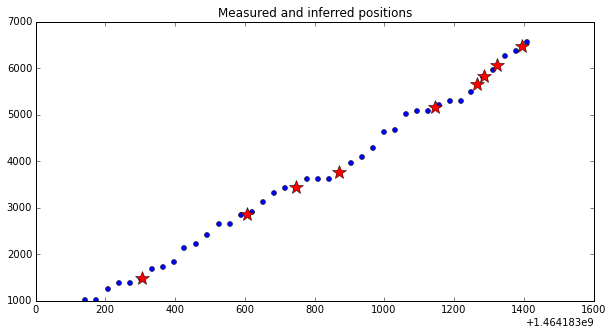

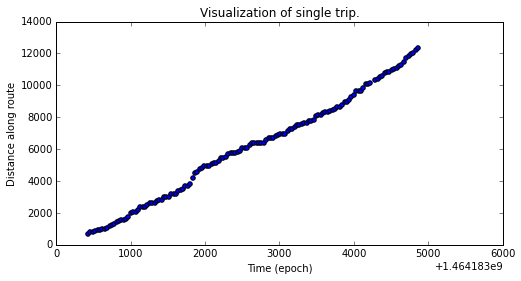

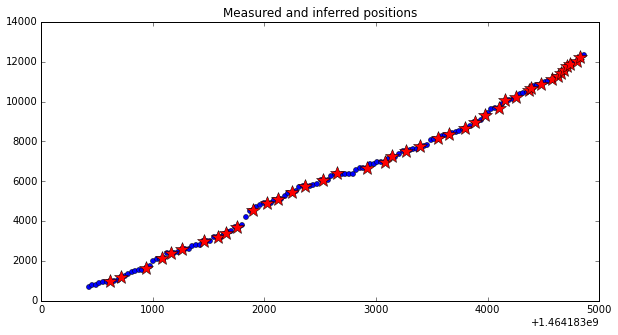

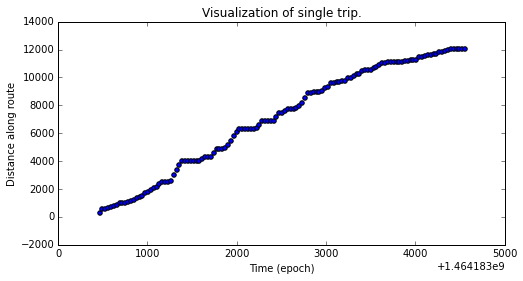

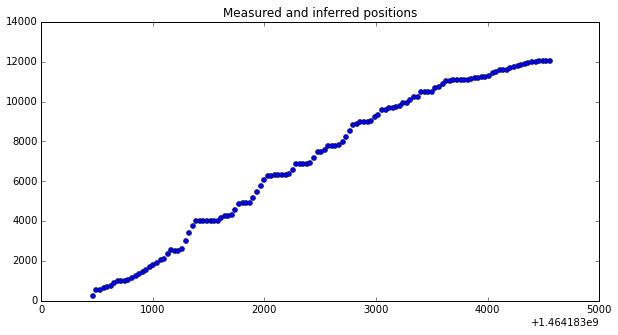

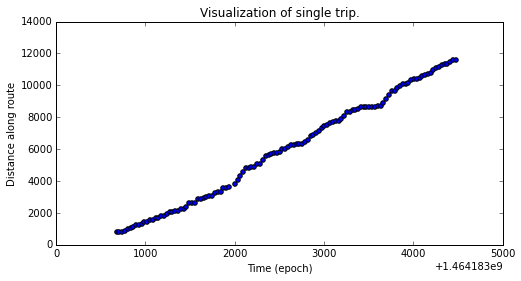

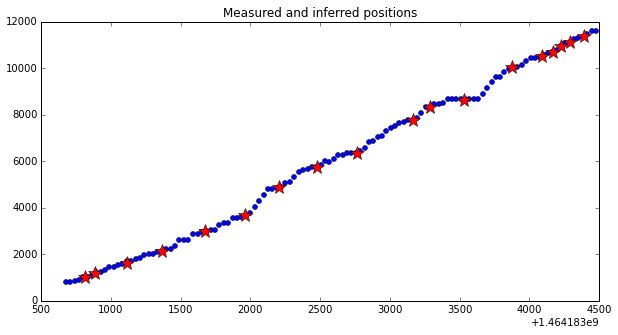

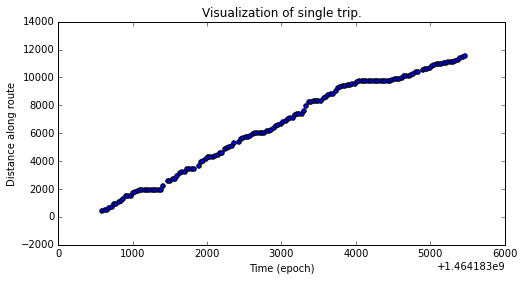

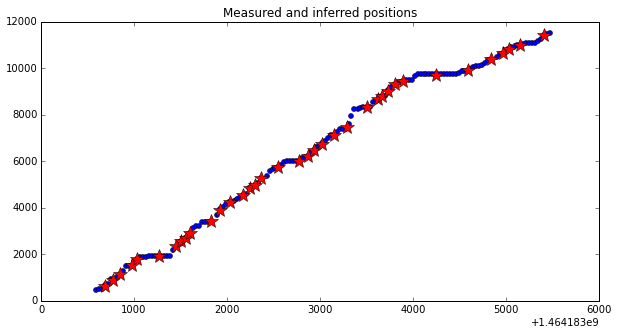

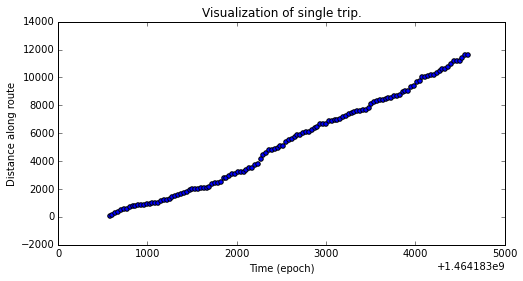

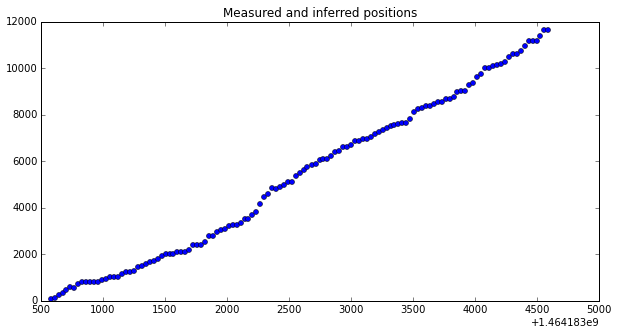

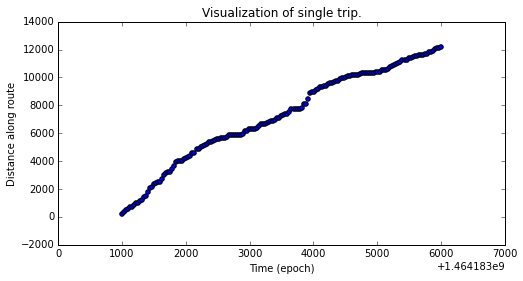

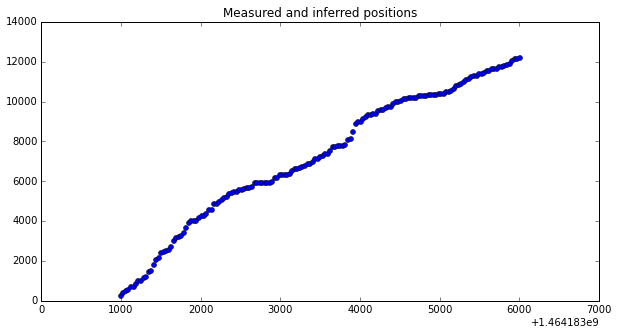

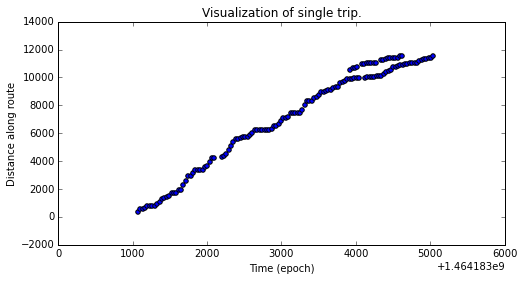

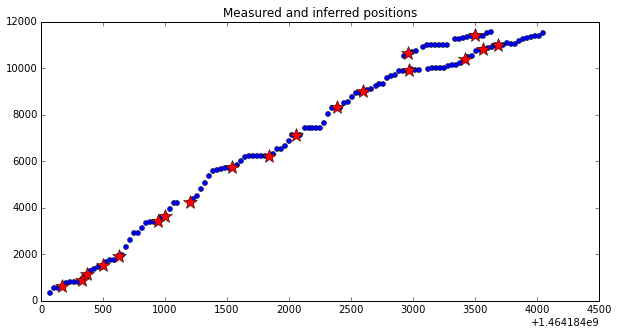

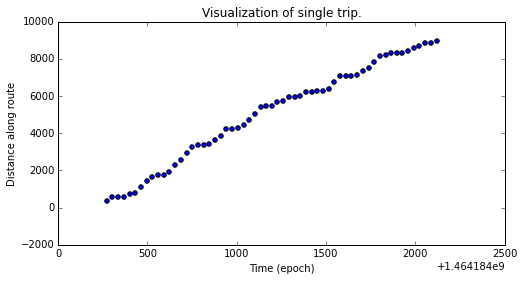

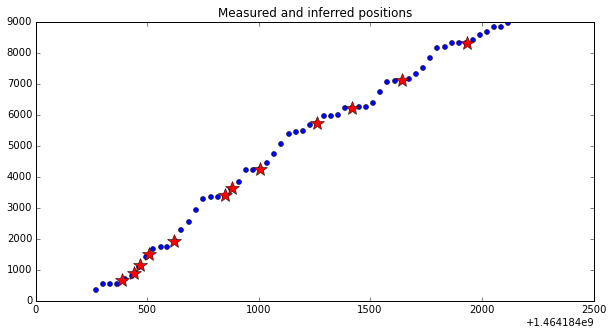

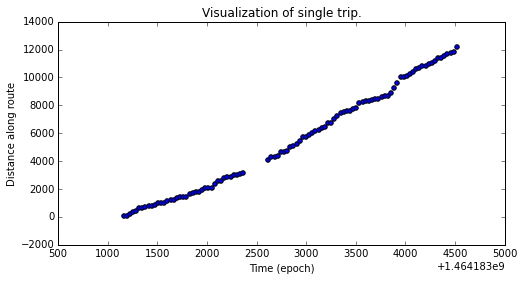

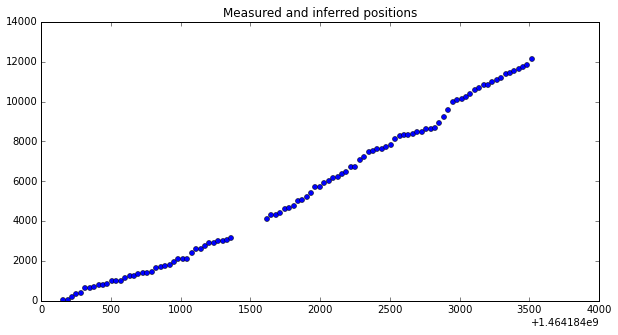

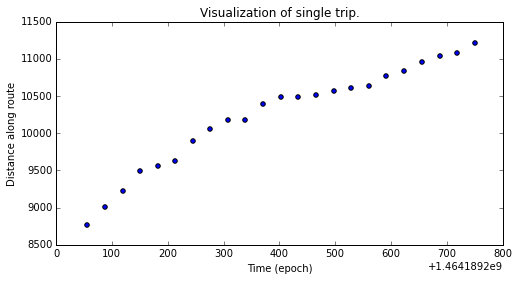

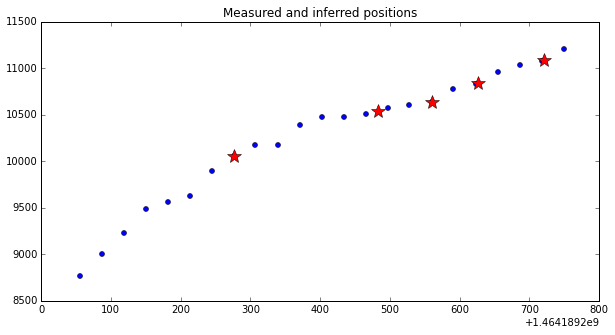

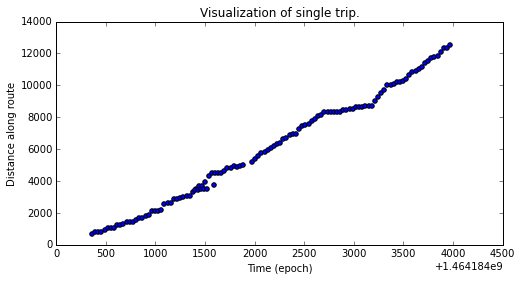

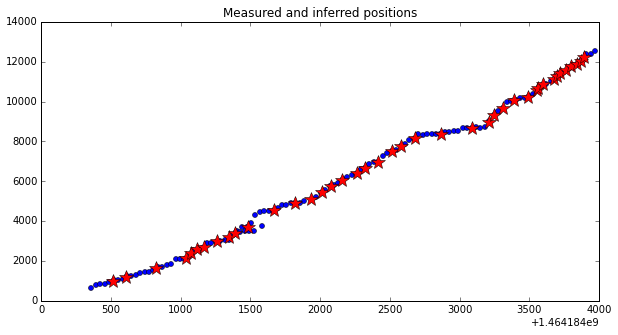

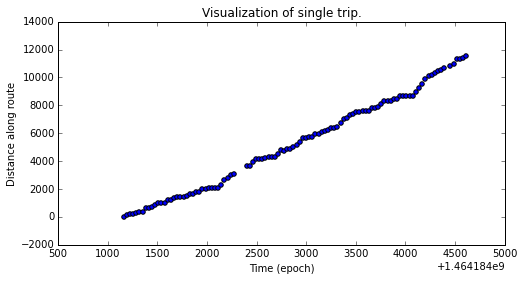

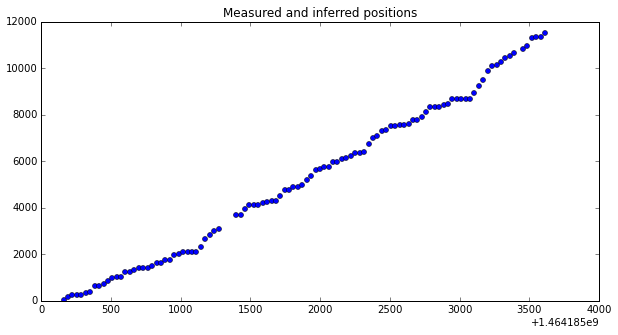

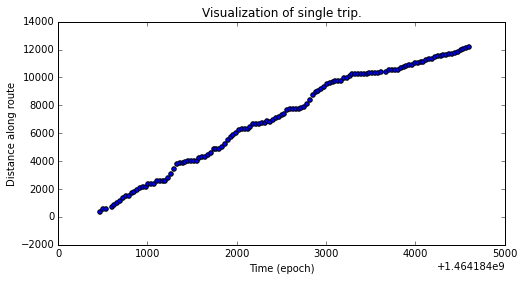

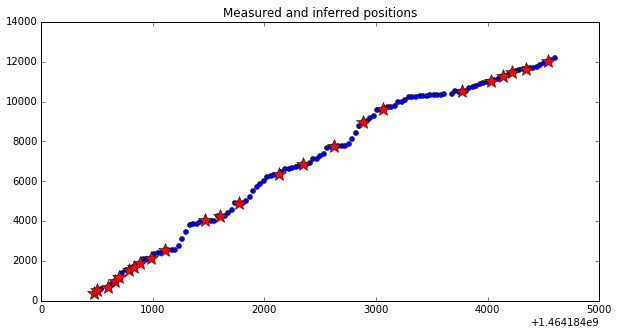

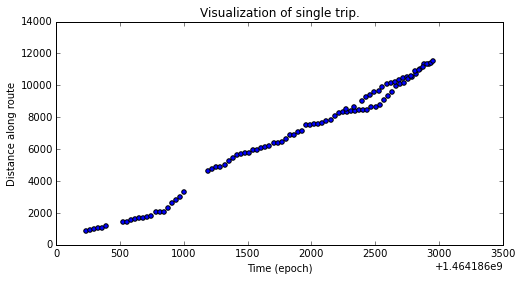

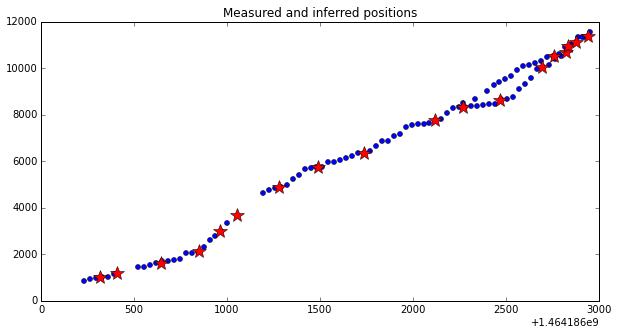

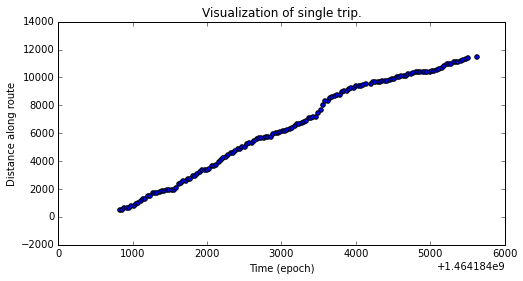

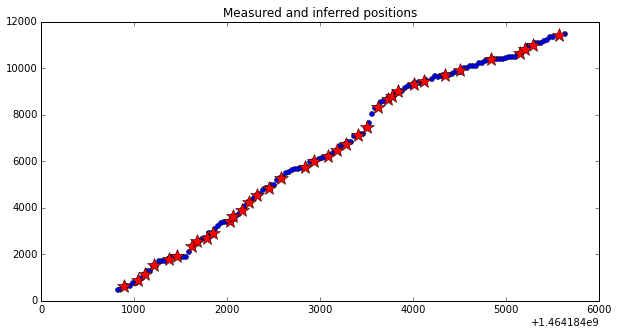

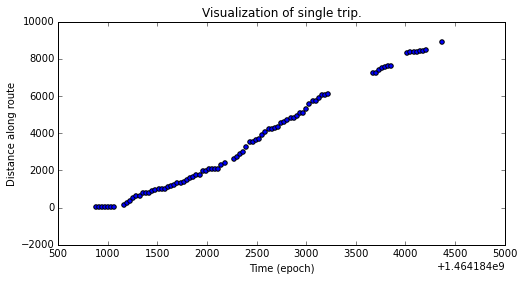

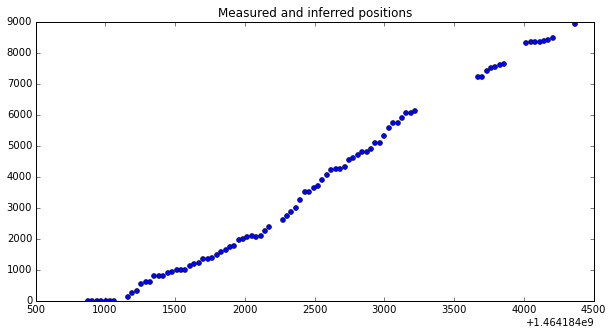

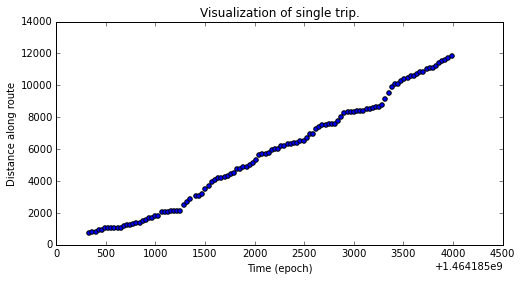

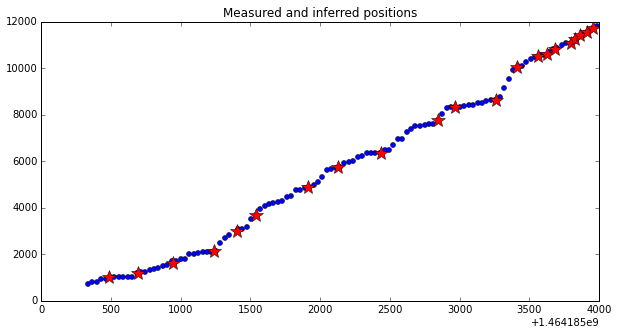

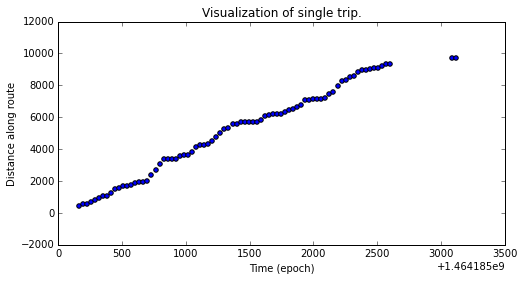

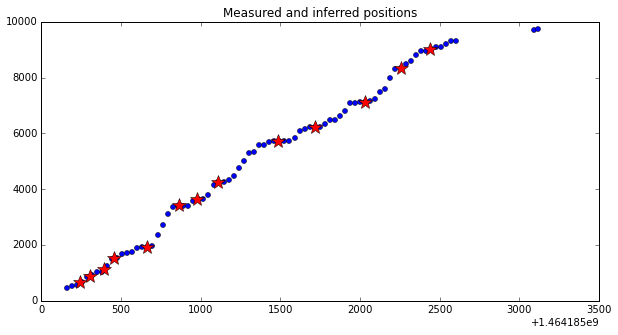

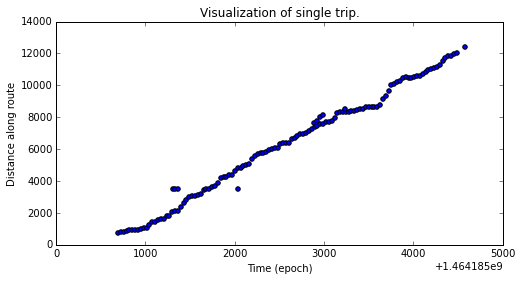

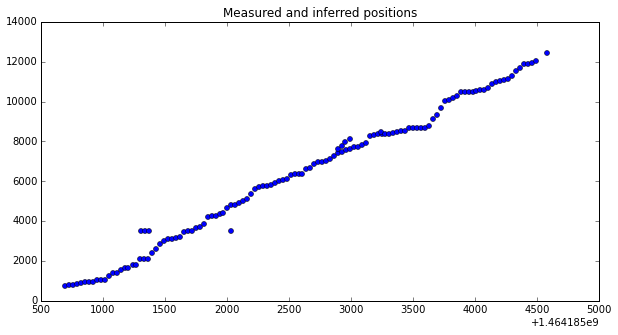

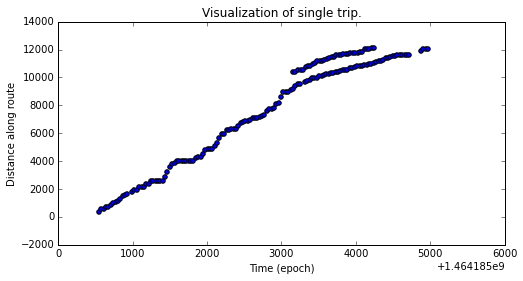

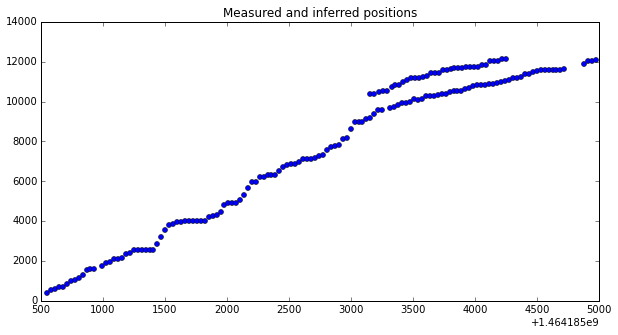

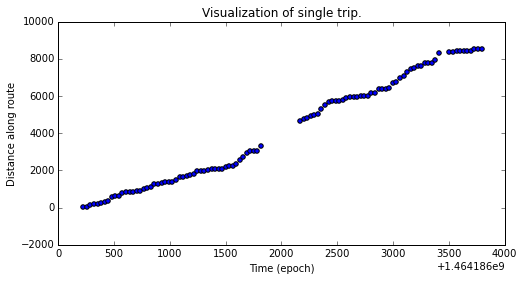

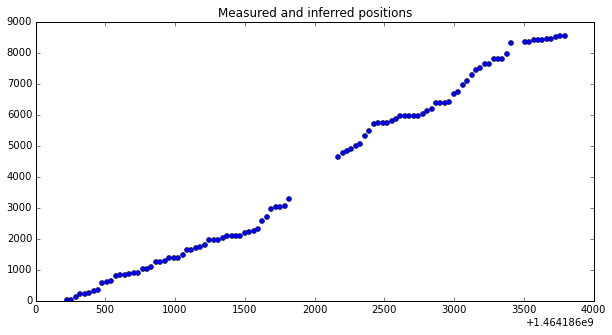

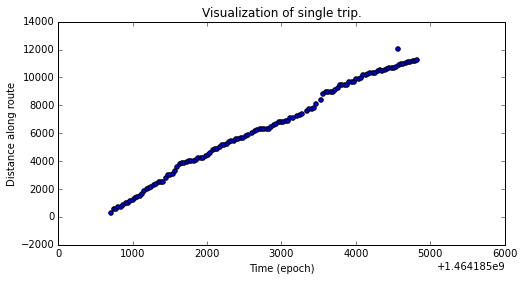

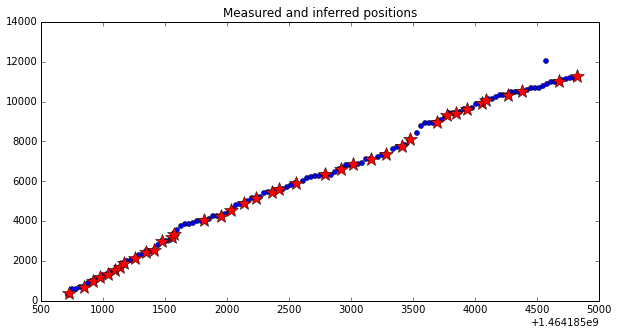

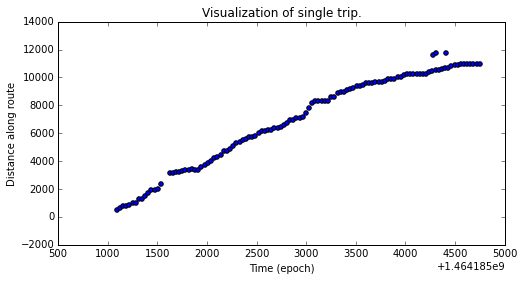

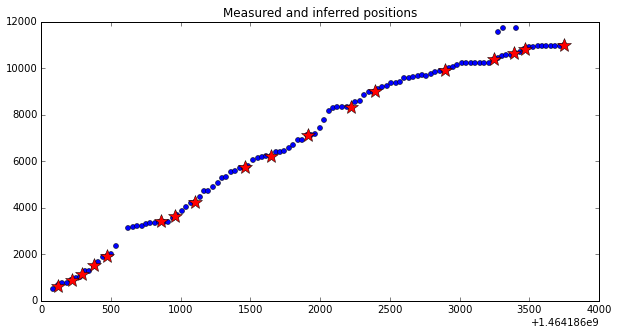

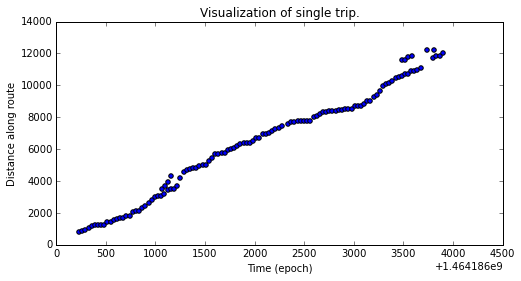

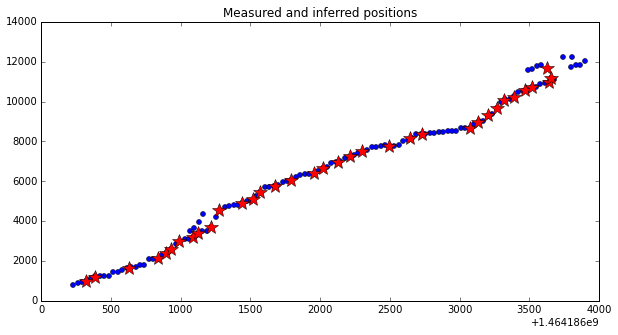

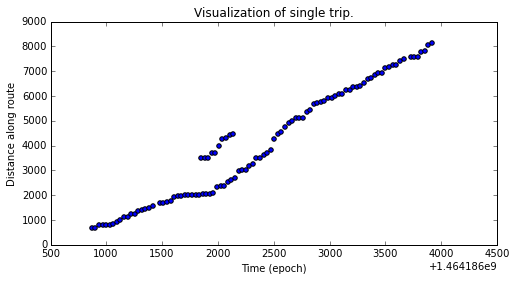

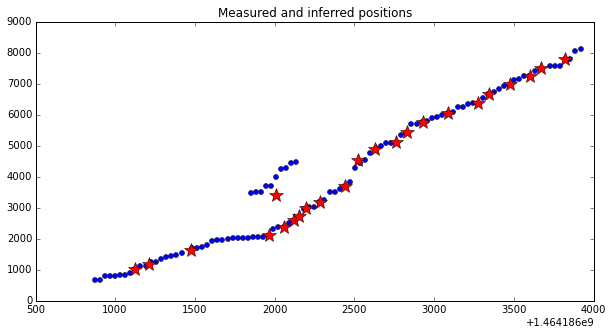

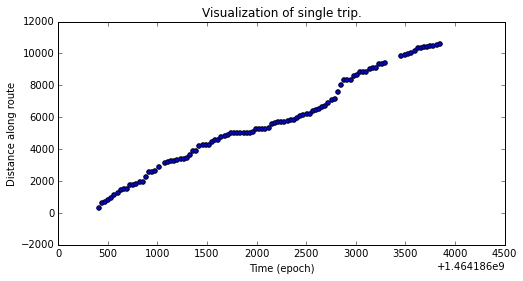

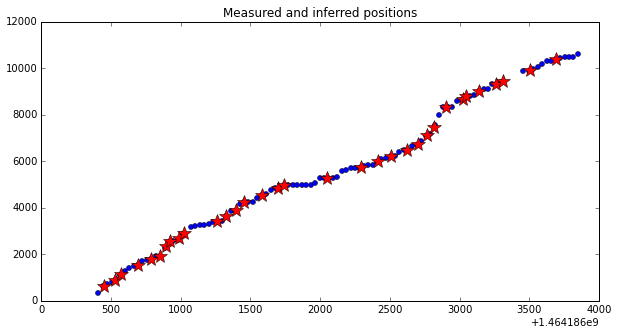

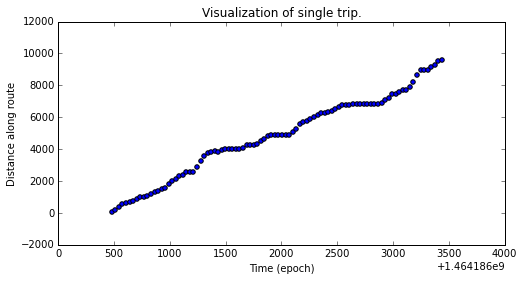

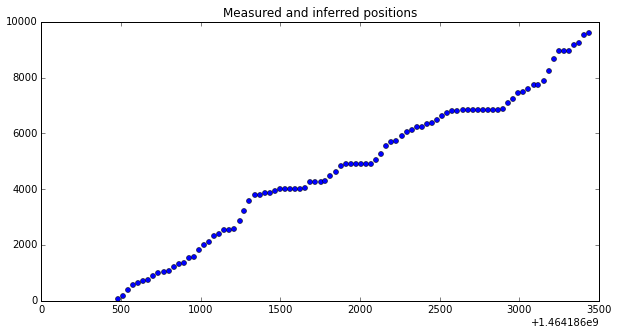

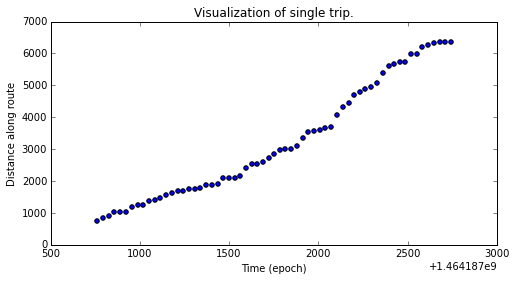

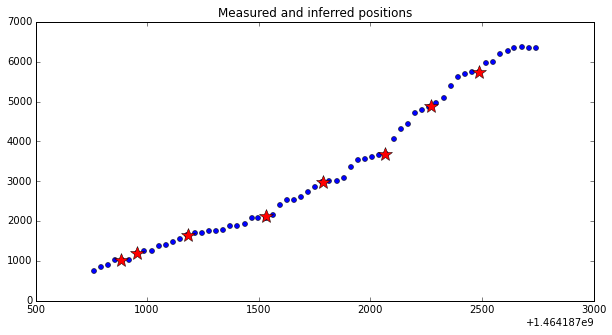

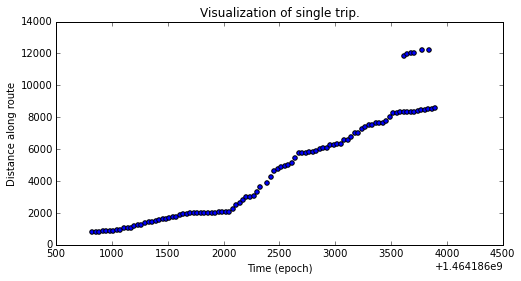

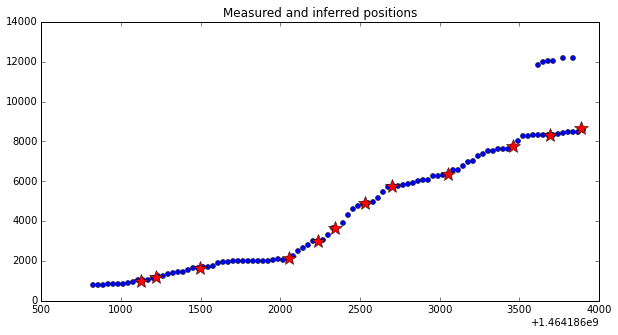

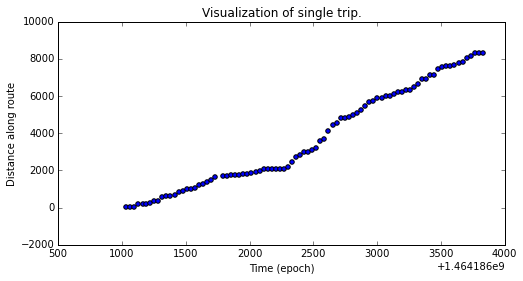

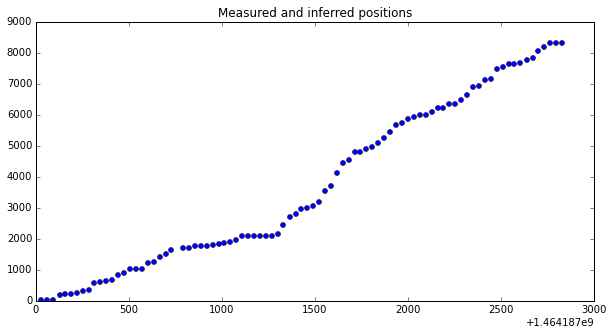

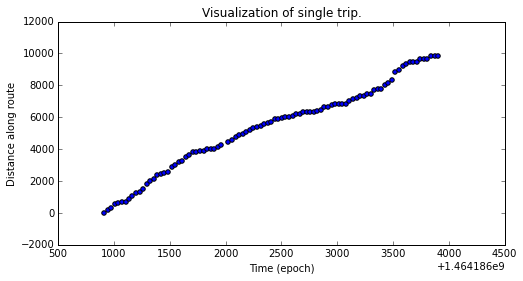

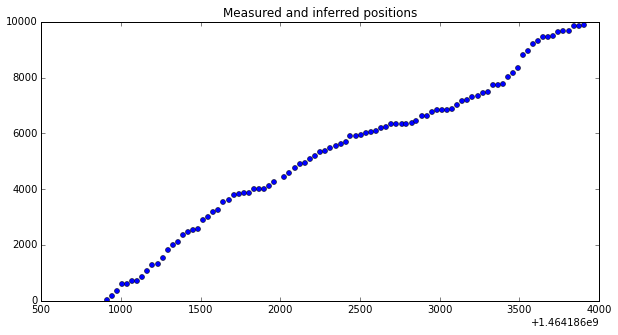

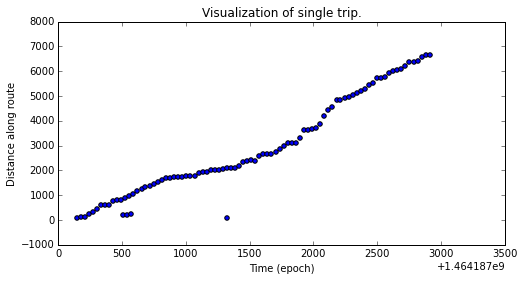

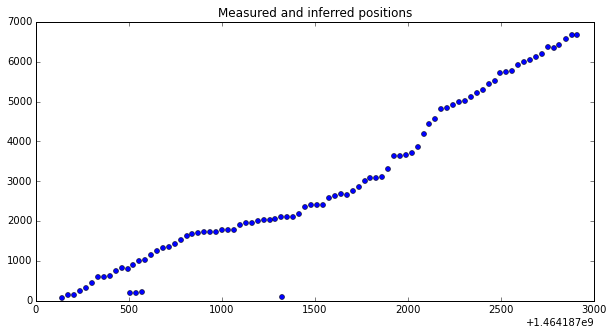

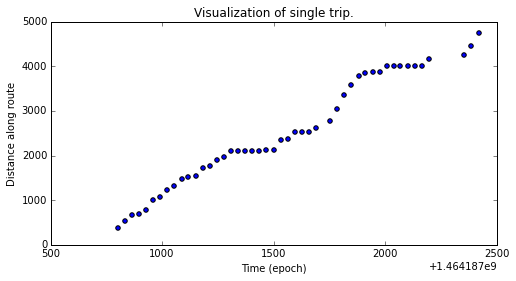

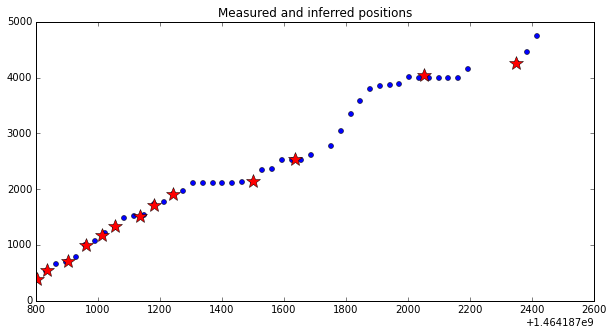

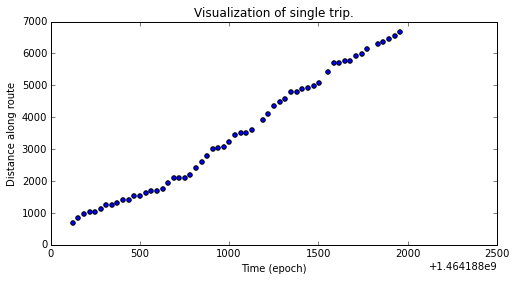

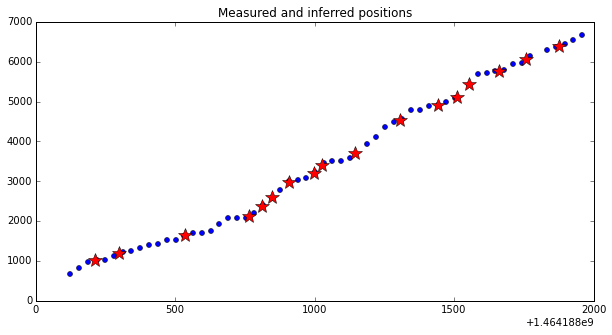

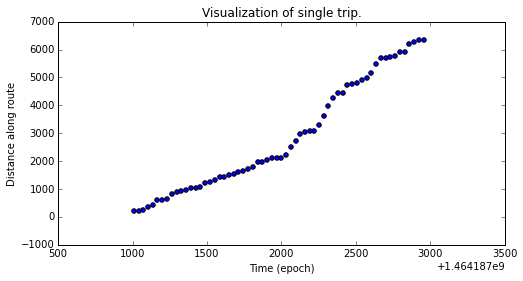

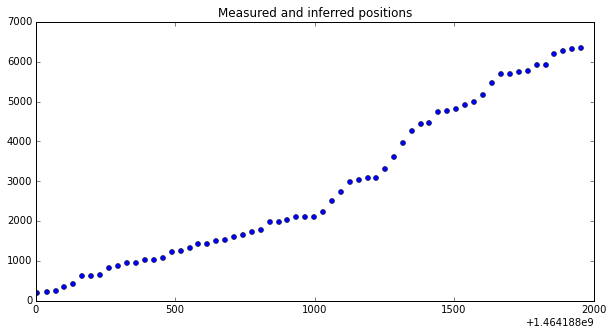

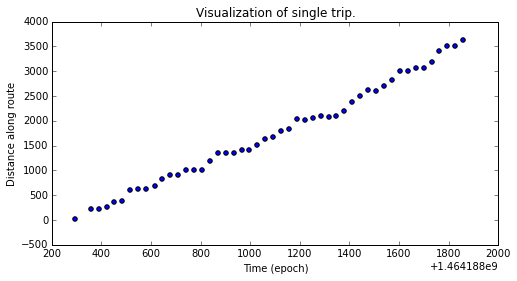

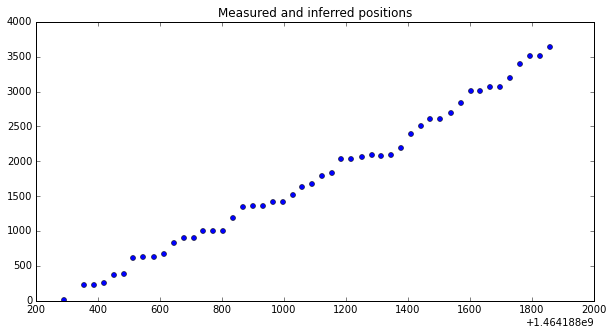

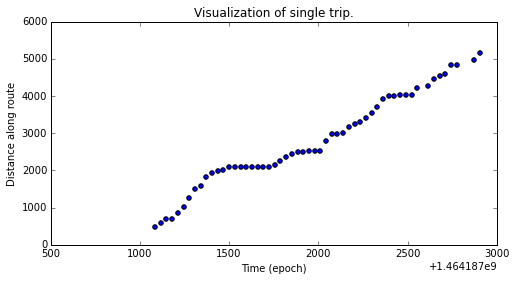

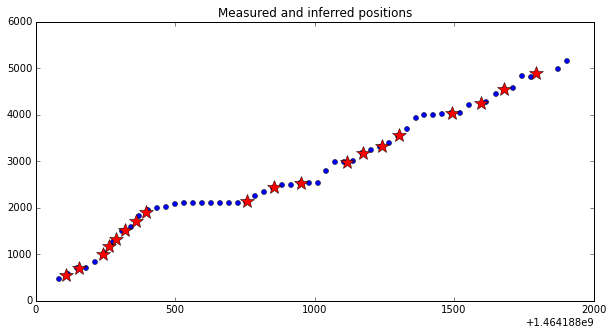

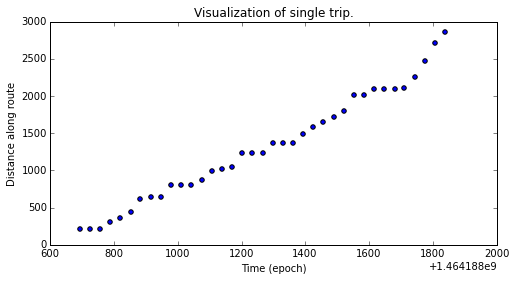

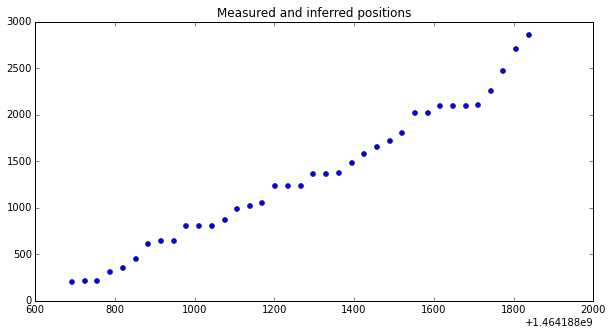

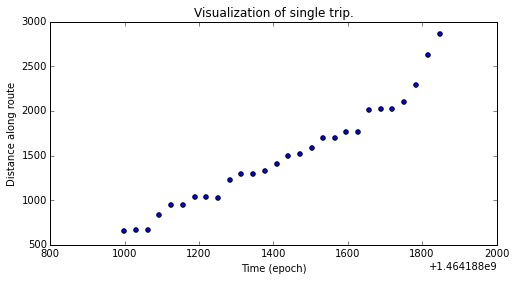

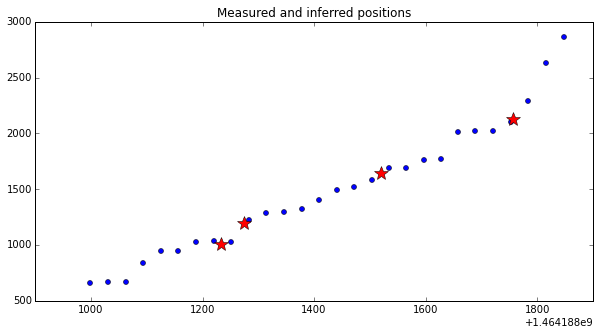

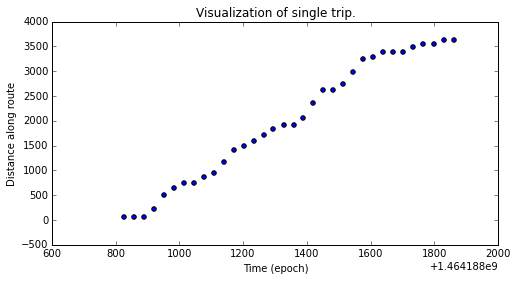

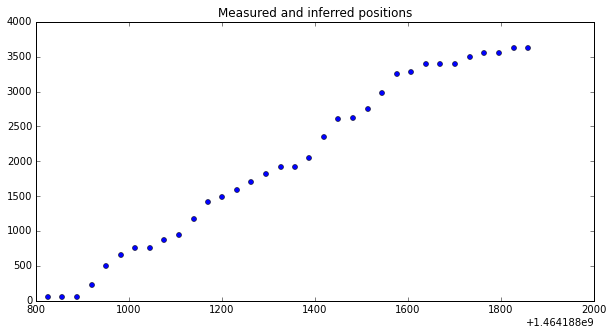

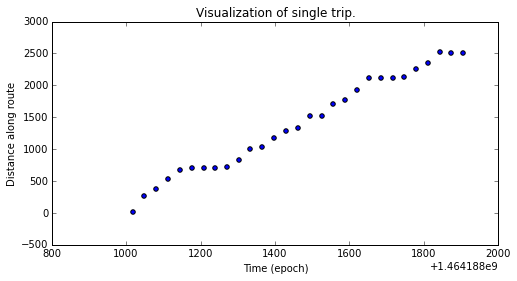

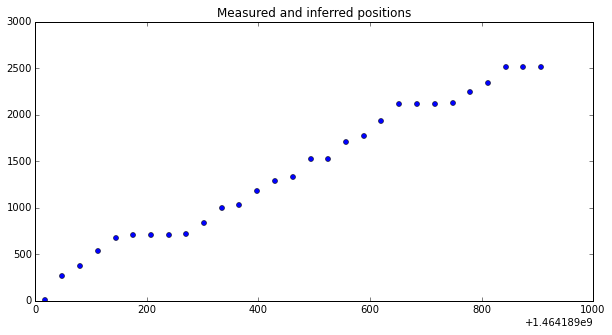

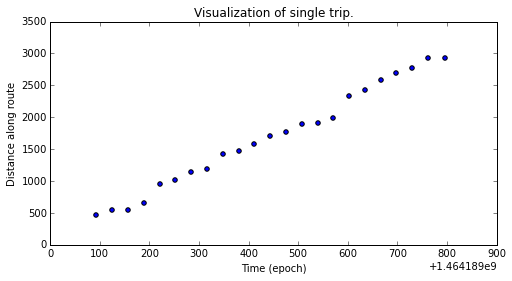

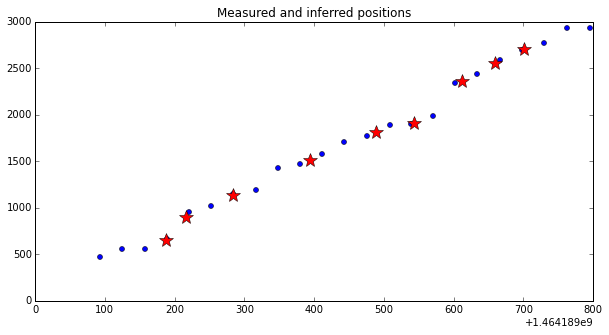

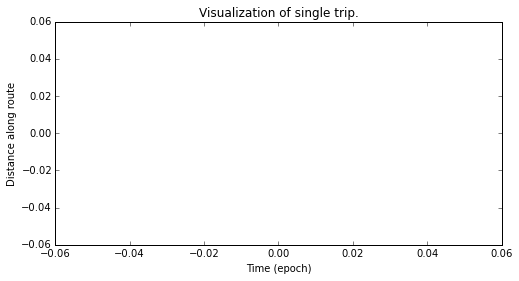

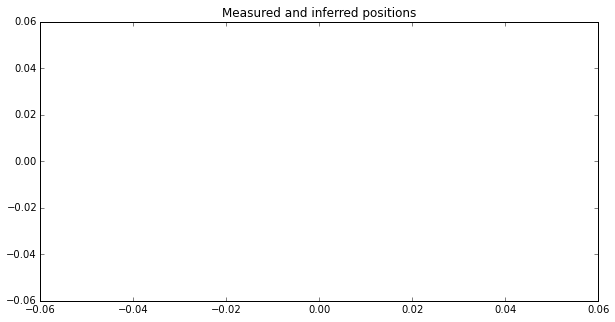

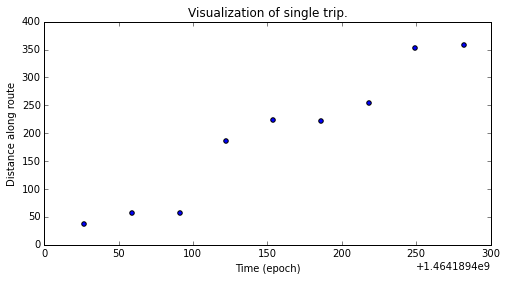

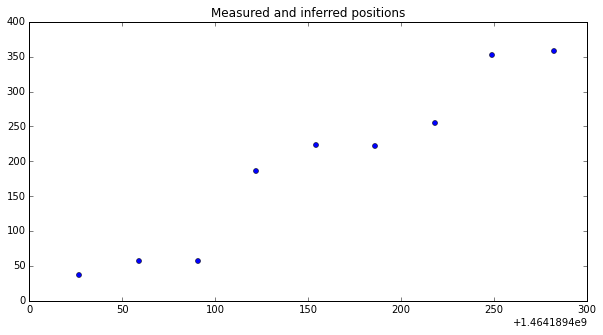

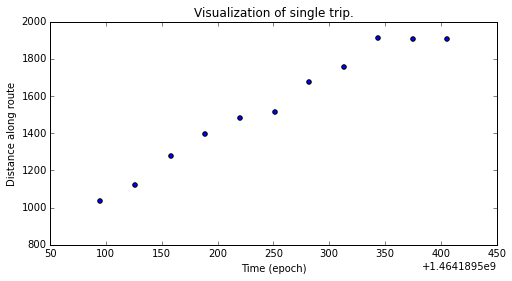

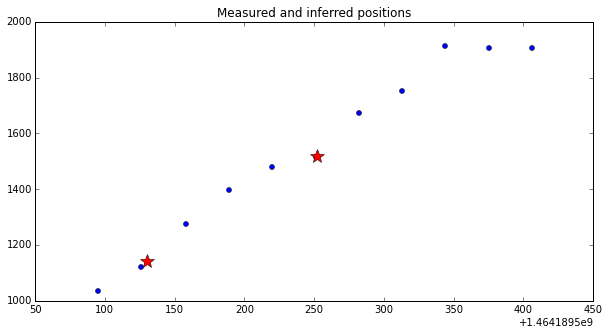

In [ ]:
data = pd.read_csv('longjsons_parsed.csv')
data.drop_duplicates(['vehicleID','RecordedAtTime'],inplace=True)
data.set_index(['Line','Trip','TripDate','vehicleID','RecordedAtTime'],inplace=True,drop=True,verify_integrity=True)
# for now, use a truncated data set.  just get data for one line (M5).
tripDateLookup = "2016-05-25"
lineLookup = "MTA NYCT_B41"
avl_long = data.xs((lineLookup,tripDateLookup),level=(0,2),drop_level=False)

trips = pd.unique(avl_long.index.get_level_values('Trip'))
for tp in trips:
    try:
        interpolate_stops(avl_long[avl_long.index.get_level_values('Trip') == tp])
    except ValueError:
        continue
    except IndexError:
        continue

In [8]:
data.index.get_level_values('Trip')

Index([u'MTA NYCT_FB_B6-Weekday-SDon-043400_B41_16',
       u'MTA NYCT_FB_B6-Weekday-SDon-040800_B41_28',
       u'MTA NYCT_FB_B6-Weekday-SDon-042300_B41_30',
       u'MTA NYCT_FB_B6-Weekday-SDon-044100_B41_33',
       u'MTA NYCT_FB_B6-Weekday-SDon-041000_B41_25',
       u'MTA NYCT_FB_B6-Weekday-SDon-043900_B41_1',
       u'MTA NYCT_FB_B6-Weekday-SDon-044300_B41_22',
       u'MTA NYCT_FB_B6-Weekday-SDon-041400_B41_13',
       u'MTA NYCT_FB_B6-Weekday-SDon-038300_B41_18',
       u'MTA NYCT_FB_B6-Weekday-SDon-040800_B41_7', 
       ...
       u'MTA NYCT_FB_B6-Weekday-SDon-063500_B41_26',
       u'MTA NYCT_FB_B6-Weekday-SDon-068200_B41_49',
       u'MTA NYCT_FB_B6-Weekday-SDon-063900_B41_13',
       u'MTA NYCT_FB_B6-Weekday-SDon-064900_B41_5',
       u'MTA NYCT_FB_B6-Weekday-SDon-065900_B41_34',
       u'MTA NYCT_FB_B6-Weekday-SDon-064300_B41_25',
       u'MTA NYCT_FB_B6-Weekday-SDon-065900_B41_6',
       u'MTA NYCT_FB_B6-Weekday-SDon-061900_B41_21',
       u'MTA NYCT_FB_B6-Weekday-SDon-0

#### Note: sometimes the stations are missing but maybe this can be solved without GTFS after all the trips are aggregated.